wumps

# **batch size**

**batchsize=128**

Episode 1 finished after 9 steps with total reward -1008
Episode 2 finished after 9 steps with total reward -1008
Episode 3 finished after 22 steps with total reward -1021
Episode 4 finished after 2 steps with total reward -1001
Episode 5 finished after 3 steps with total reward -1002
Episode 6 finished after 3 steps with total reward -1002
Episode 7 finished after 17 steps with total reward -1016
Episode 8 finished after 14 steps with total reward -1013
Episode 9 finished after 11 steps with total reward -1010
Episode 10 finished after 3 steps with total reward -1002
Episode 11 finished after 13 steps with total reward -1012
Episode 12 finished after 17 steps with total reward 135
Episode 13 finished after 8 steps with total reward -1007
Episode 14 finished after 16 steps with total reward -1015
Episode 15 finished after 11 steps with total reward -1010
Episode 16 finished after 8 steps with total reward -1007
Episode 17 finished after 10 steps with total reward -1009
Episode 18 finis

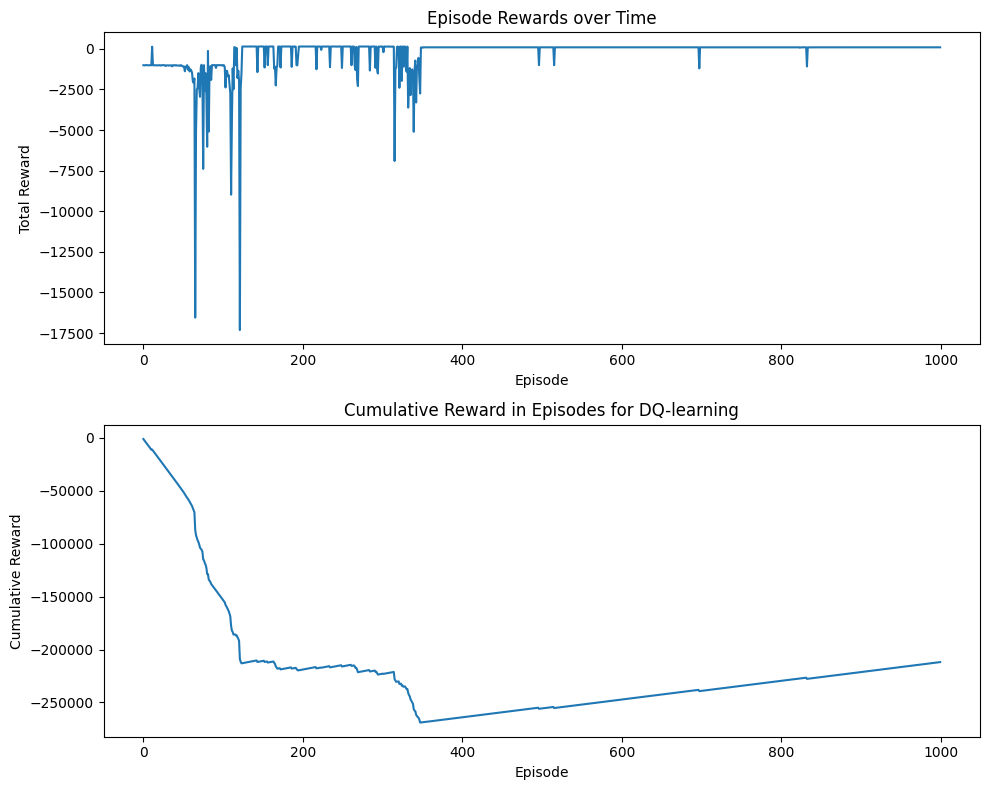

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1000
TAU = 0.001
LR = 0.0001
MEMORY_CAPACITY = 10000

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    plt.tight_layout()
    plt.show()


**batchsize=64**

Episode 1 finished after 12 steps with total reward -1011
Episode 2 finished after 7 steps with total reward -1006
Episode 3 finished after 24 steps with total reward -1023
Episode 4 finished after 22 steps with total reward -1021
Episode 5 finished after 15 steps with total reward -1014
Episode 6 finished after 5 steps with total reward -1004
Episode 7 finished after 7 steps with total reward -1006
Episode 8 finished after 7 steps with total reward -1006
Episode 9 finished after 10 steps with total reward -1009
Episode 10 finished after 16 steps with total reward -1015
Episode 11 finished after 6 steps with total reward -1005
Episode 12 finished after 3 steps with total reward -1002
Episode 13 finished after 2 steps with total reward -1001
Episode 14 finished after 11 steps with total reward -1010
Episode 15 finished after 5 steps with total reward -1004
Episode 16 finished after 11 steps with total reward 90
Episode 17 finished after 10 steps with total reward -1009
Episode 18 finish

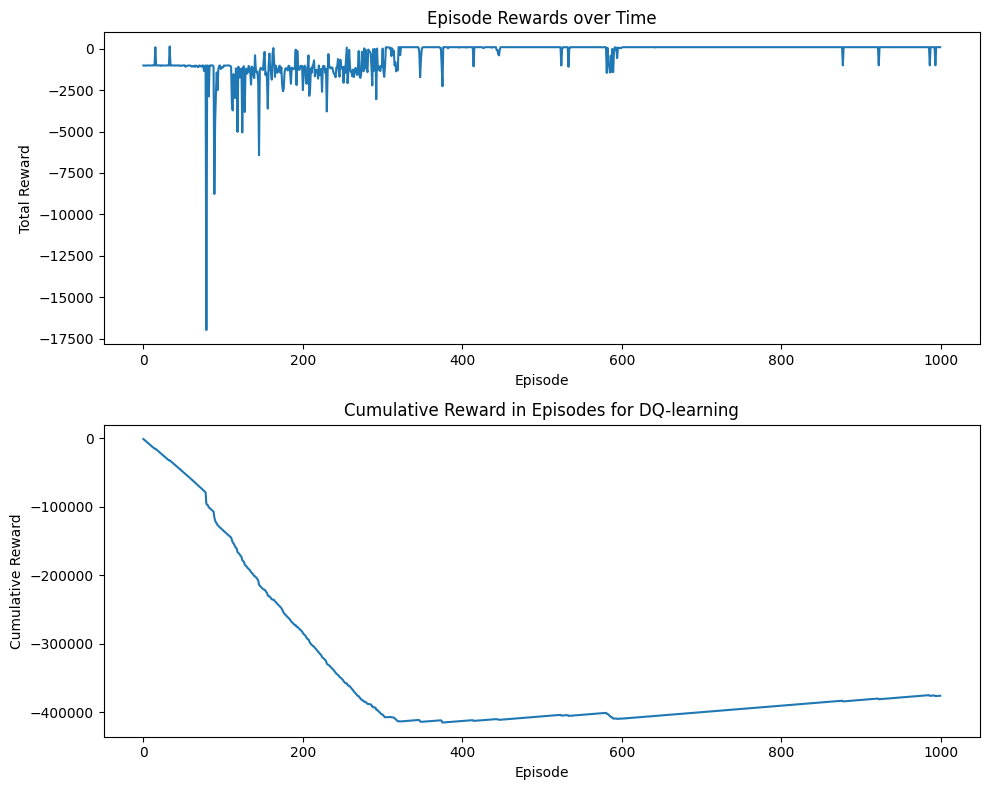

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1000
TAU = 0.001
LR = 0.0001
MEMORY_CAPACITY = 10000

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    plt.tight_layout()
    plt.show()


**batchsize=32**

Episode 1 finished after 3 steps with total reward -1002
Episode 2 finished after 11 steps with total reward -1010
Episode 3 finished after 5 steps with total reward -1004
Episode 4 finished after 52 steps with total reward -1051
Episode 5 finished after 14 steps with total reward -1013
Episode 6 finished after 5 steps with total reward -1004
Episode 7 finished after 5 steps with total reward -1004
Episode 8 finished after 10 steps with total reward -1009
Episode 9 finished after 6 steps with total reward -1005
Episode 10 finished after 18 steps with total reward -1017
Episode 11 finished after 24 steps with total reward -1023
Episode 12 finished after 8 steps with total reward -1007
Episode 13 finished after 12 steps with total reward -1011
Episode 14 finished after 16 steps with total reward -1015
Episode 15 finished after 5 steps with total reward -1004
Episode 16 finished after 17 steps with total reward -1016
Episode 17 finished after 11 steps with total reward -1010
Episode 18 fi

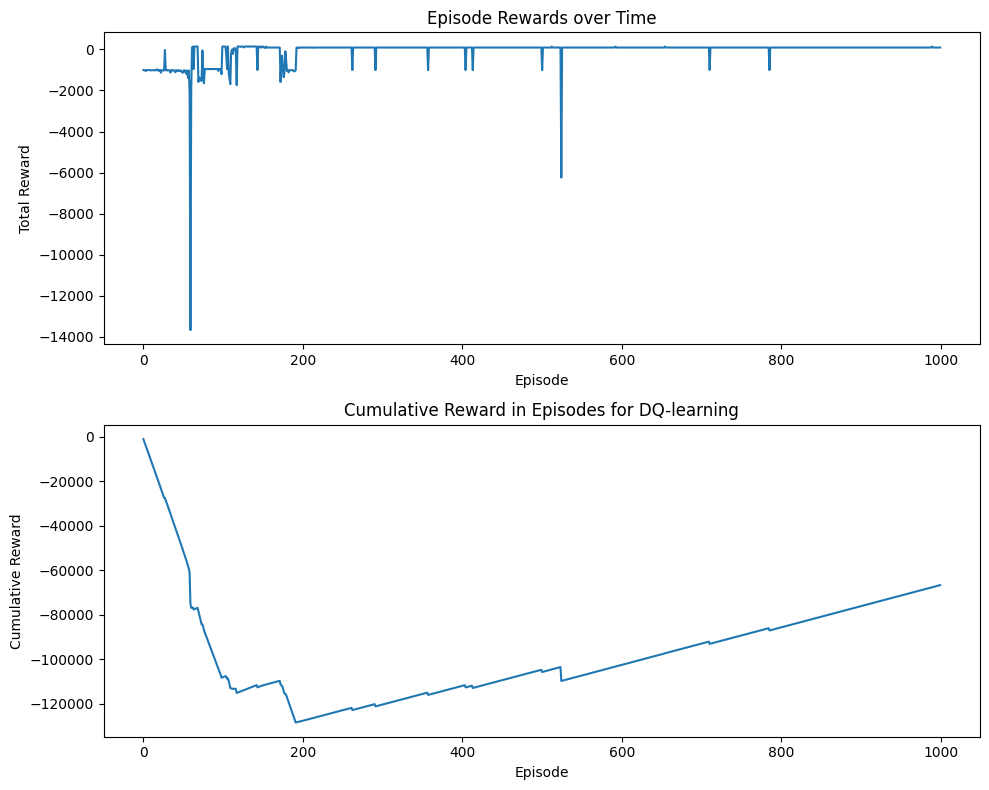

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1000
TAU = 0.001
LR = 0.0001
MEMORY_CAPACITY = 10000

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    plt.tight_layout()
    plt.show()


# **Tau**

**0.00001**

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1000
TAU = 0.0001
LR = 0.0001
MEMORY_CAPACITY = 10000

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


Episode 1 finished after 5 steps with total reward -1004
Episode 2 finished after 20 steps with total reward -1019
Episode 3 finished after 9 steps with total reward -1008
Episode 4 finished after 3 steps with total reward -1002
Episode 5 finished after 10 steps with total reward -1009
Episode 6 finished after 26 steps with total reward 75
Episode 7 finished after 3 steps with total reward -1002
Episode 8 finished after 5 steps with total reward -1004
Episode 9 finished after 4 steps with total reward -1003
Episode 10 finished after 3 steps with total reward -1002
Episode 11 finished after 2 steps with total reward -1001
Episode 12 finished after 10 steps with total reward -1009
Episode 13 finished after 11 steps with total reward 90
Episode 14 finished after 2 steps with total reward -1001
Episode 15 finished after 2 steps with total reward -1001
Episode 16 finished after 7 steps with total reward -1006
Episode 17 finished after 17 steps with total reward -1016
Episode 18 finished aft

KeyboardInterrupt: 

**tau=0.001**

***neuron128***

Episode 1 finished after 10 steps with total reward -1009
Episode 2 finished after 12 steps with total reward -1011
Episode 3 finished after 15 steps with total reward 86
Episode 4 finished after 13 steps with total reward -1012
Episode 5 finished after 3 steps with total reward -1002
Episode 6 finished after 2 steps with total reward -1001
Episode 7 finished after 11 steps with total reward -1010
Episode 8 finished after 21 steps with total reward 80
Episode 9 finished after 4 steps with total reward -1003
Episode 10 finished after 8 steps with total reward -1007
Episode 11 finished after 13 steps with total reward -1012
Episode 12 finished after 6 steps with total reward -1005
Episode 13 finished after 26 steps with total reward -1025
Episode 14 finished after 5 steps with total reward -1004
Episode 15 finished after 13 steps with total reward -1012
Episode 16 finished after 21 steps with total reward -1020
Episode 17 finished after 89 steps with total reward -1088
Episode 18 finishe

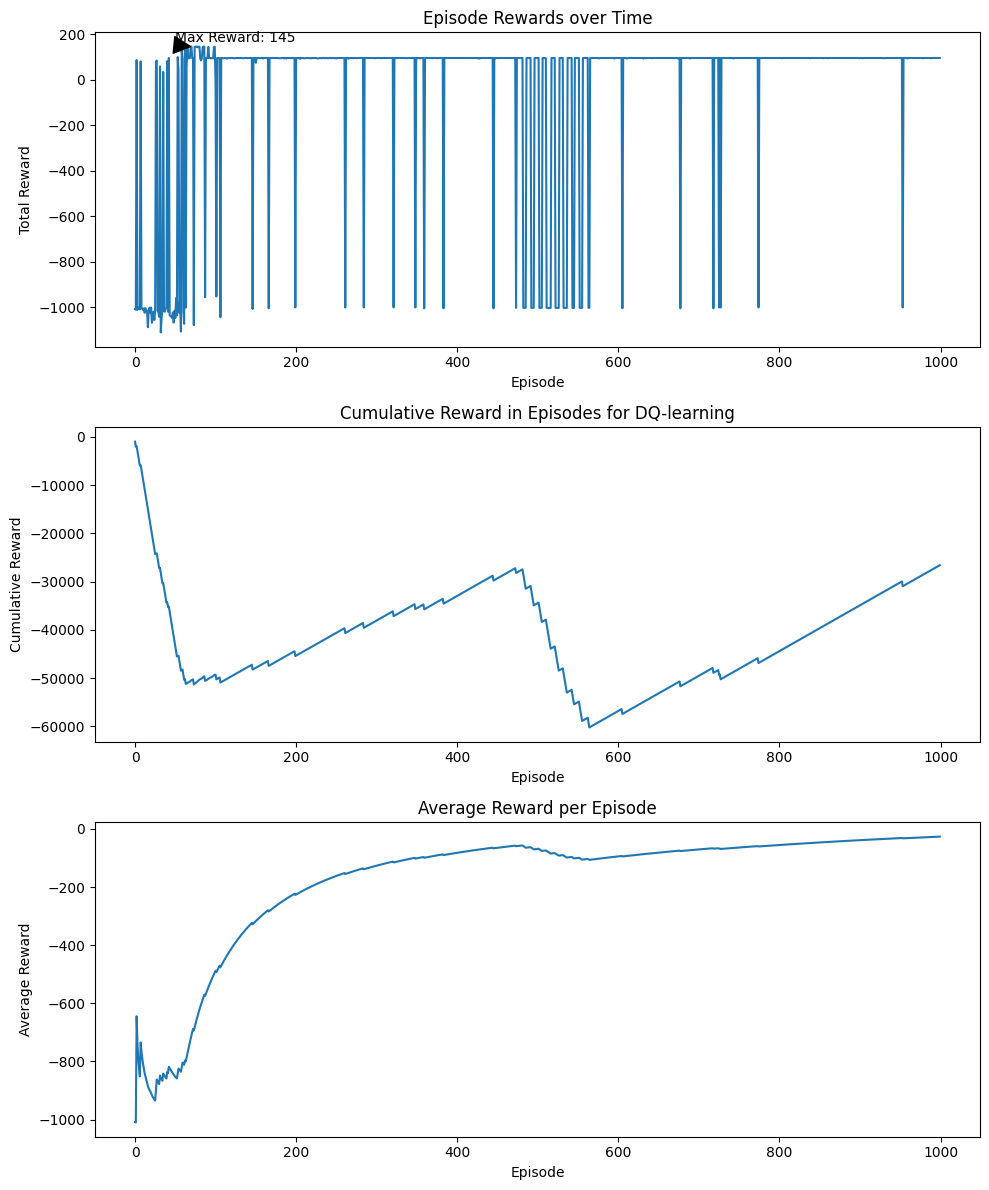

Average reward per episode after 1000 episodes: -26.609


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1000
TAU = 0.001
LR = 0.0001
MEMORY_CAPACITY = 10000


# Main training loop

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")

***neuron24***

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1000
TAU = 0.001
LR = 0.0001
MEMORY_CAPACITY = 10000


# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


Episode 1 finished after 2 steps with total reward -1001
Episode 2 finished after 6 steps with total reward -1005
Episode 3 finished after 2 steps with total reward -1001
Episode 4 finished after 3 steps with total reward -1002
Episode 5 finished after 4 steps with total reward -1003
Episode 6 finished after 7 steps with total reward -1006
Episode 7 finished after 20 steps with total reward -1019
Episode 8 finished after 3 steps with total reward -1002
Episode 9 finished after 3 steps with total reward -1002
Episode 10 finished after 11 steps with total reward -1010
Episode 11 finished after 3 steps with total reward -1002
Episode 12 finished after 5 steps with total reward -1004
Episode 13 finished after 12 steps with total reward -1011
Episode 14 finished after 8 steps with total reward -1007
Episode 15 finished after 10 steps with total reward -1009
Episode 16 finished after 4 steps with total reward -1003
Episode 17 finished after 4 steps with total reward -1003
Episode 18 finished

Average reward per episode after 1000 episodes: -55.277


**tau=0.1**

***neuron128***

Episode 1 finished after 3 steps with total reward -1002
Episode 2 finished after 5 steps with total reward -1004
Episode 3 finished after 5 steps with total reward -1004
Episode 4 finished after 18 steps with total reward -1017
Episode 5 finished after 10 steps with total reward -1009
Episode 6 finished after 5 steps with total reward -1004
Episode 7 finished after 33 steps with total reward -981
Episode 8 finished after 9 steps with total reward -1008
Episode 9 finished after 14 steps with total reward -1013
Episode 10 finished after 24 steps with total reward -1023
Episode 11 finished after 17 steps with total reward -1016
Episode 12 finished after 7 steps with total reward -1006
Episode 13 finished after 13 steps with total reward -1012
Episode 14 finished after 3 steps with total reward -1002
Episode 15 finished after 7 steps with total reward -1006
Episode 16 finished after 2 steps with total reward -1001
Episode 17 finished after 2 steps with total reward -1001
Episode 18 finish

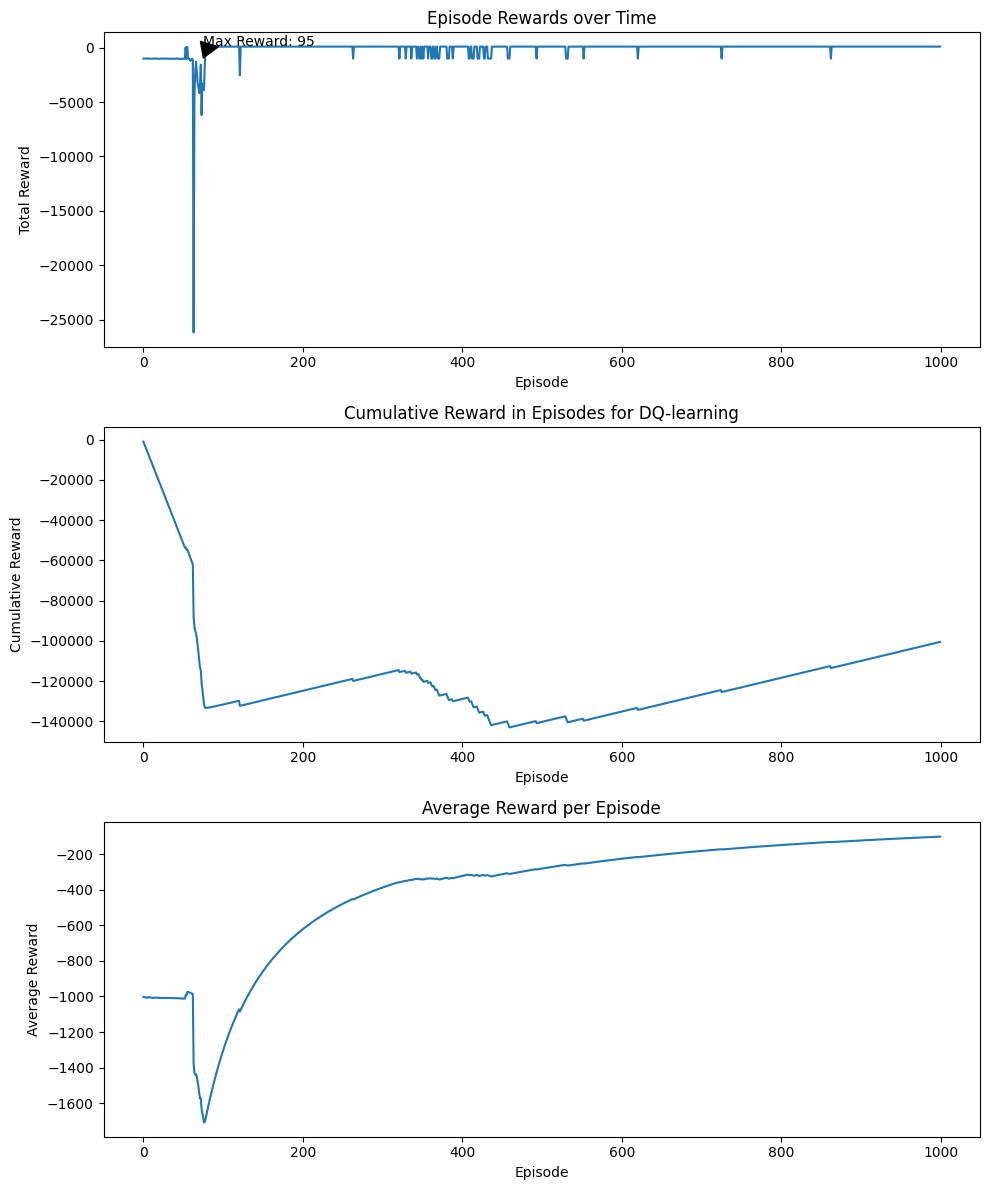

Average reward per episode after 1000 episodes: -100.553


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1000
TAU = 0.1
LR = 0.0001
MEMORY_CAPACITY = 10000


# Main training loop

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")

***neuron24***

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1000
TAU = 0.1
LR = 0.0001
MEMORY_CAPACITY = 10000


# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


Episode 1 finished after 14 steps with total reward -1013
Episode 2 finished after 17 steps with total reward -1016
Episode 3 finished after 17 steps with total reward -965
Episode 4 finished after 6 steps with total reward -1005
Episode 5 finished after 4 steps with total reward -1003
Episode 6 finished after 3 steps with total reward -1002
Episode 7 finished after 65 steps with total reward 36
Episode 8 finished after 13 steps with total reward -1012
Episode 9 finished after 11 steps with total reward -1010
Episode 10 finished after 14 steps with total reward -1013
Episode 11 finished after 18 steps with total reward -1017
Episode 12 finished after 35 steps with total reward -983
Episode 13 finished after 35 steps with total reward -1034
Episode 14 finished after 27 steps with total reward -1026
Episode 15 finished after 28 steps with total reward -1027
Episode 16 finished after 19 steps with total reward -1018
Episode 17 finished after 23 steps with total reward -1022
Episode 18 fin

Average reward per episode after 1000 episodes: -291.062


# **epsilon decay**

**epsilon decay=500**

***neuron128***

Episode 1 finished after 2 steps with total reward -1001
Episode 2 finished after 3 steps with total reward -1002
Episode 3 finished after 28 steps with total reward -1027
Episode 4 finished after 4 steps with total reward -1003
Episode 5 finished after 10 steps with total reward -1009
Episode 6 finished after 18 steps with total reward -1017
Episode 7 finished after 13 steps with total reward -1012
Episode 8 finished after 16 steps with total reward -1015
Episode 9 finished after 24 steps with total reward -1023
Episode 10 finished after 9 steps with total reward -1008
Episode 11 finished after 38 steps with total reward -1037
Episode 12 finished after 9 steps with total reward -1008
Episode 13 finished after 13 steps with total reward -1012
Episode 14 finished after 10 steps with total reward -1009
Episode 15 finished after 24 steps with total reward -972
Episode 16 finished after 36 steps with total reward 65
Episode 17 finished after 2 steps with total reward -1001
Episode 18 finis

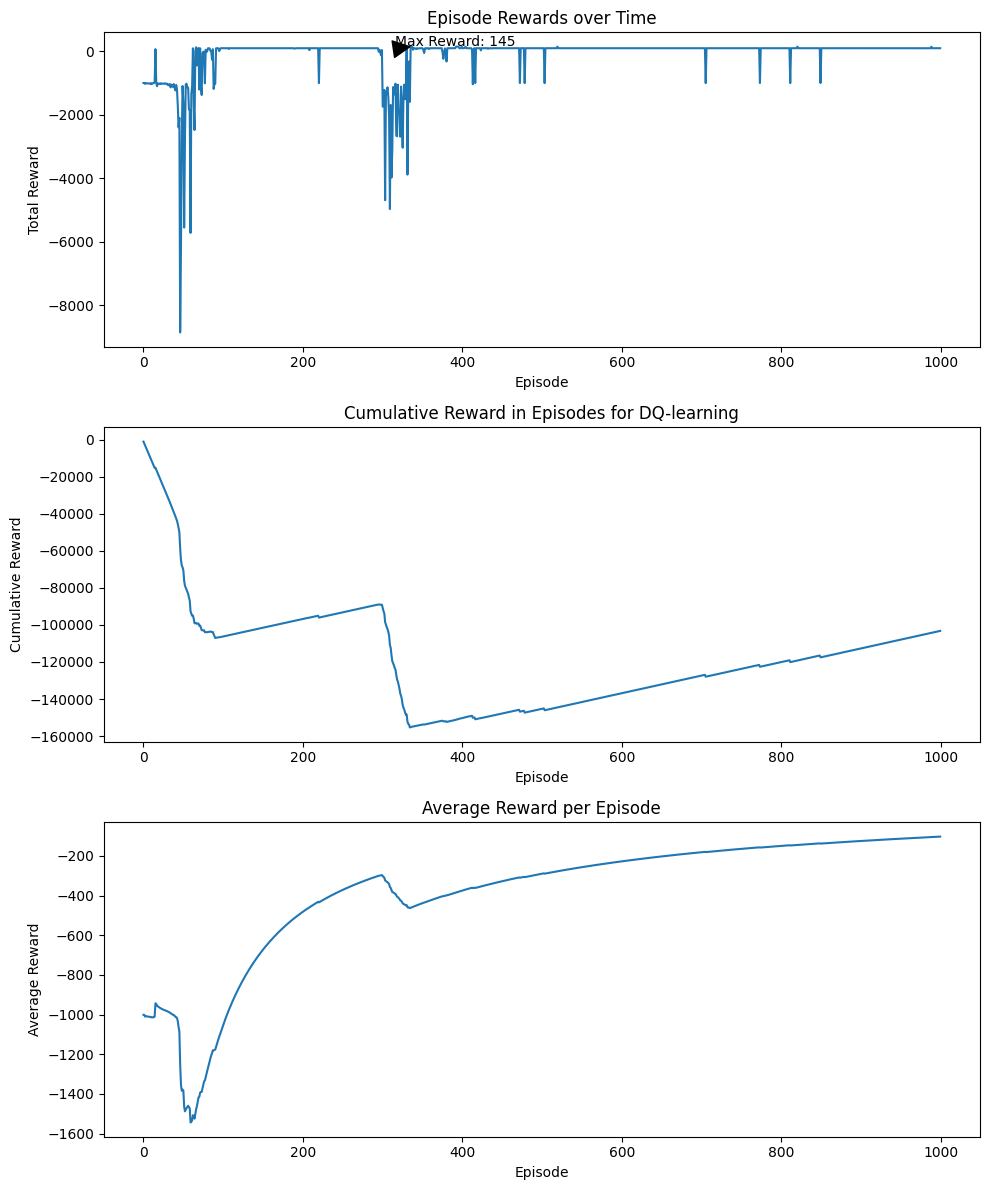

Average reward per episode after 1000 episodes: -103.213


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 500
TAU = 0.001
LR = 0.0001
MEMORY_CAPACITY = 10000



# Main training loop

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")

***neuron24***

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 500
TAU = 0.001
LR = 0.0001
MEMORY_CAPACITY = 10000


# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


Episode 1 finished after 13 steps with total reward -1012
Episode 2 finished after 3 steps with total reward -1002
Episode 3 finished after 5 steps with total reward -1004
Episode 4 finished after 5 steps with total reward -1004
Episode 5 finished after 17 steps with total reward -965
Episode 6 finished after 4 steps with total reward -1003
Episode 7 finished after 13 steps with total reward -1012
Episode 8 finished after 25 steps with total reward -1024
Episode 9 finished after 25 steps with total reward -1024
Episode 10 finished after 13 steps with total reward -1012
Episode 11 finished after 49 steps with total reward -1048
Episode 12 finished after 4 steps with total reward -1003
Episode 13 finished after 2 steps with total reward -1001
Episode 14 finished after 16 steps with total reward -1015
Episode 15 finished after 40 steps with total reward -1039
Episode 16 finished after 36 steps with total reward -1035
Episode 17 finished after 113 steps with total reward -1061
Episode 18 f

Average reward per episode after 1000 episodes: -286.728


**EPS_DECAY = 2000**

***neuron24***

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 2000
TAU = 0.001
LR = 0.0001
MEMORY_CAPACITY = 10000


# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


Episode 1 finished after 8 steps with total reward -1007
Episode 2 finished after 7 steps with total reward -1006
Episode 3 finished after 2 steps with total reward -1001
Episode 4 finished after 2 steps with total reward -1001
Episode 5 finished after 4 steps with total reward -1003
Episode 6 finished after 27 steps with total reward -1026
Episode 7 finished after 5 steps with total reward -1004
Episode 8 finished after 11 steps with total reward -1010
Episode 9 finished after 5 steps with total reward -1004
Episode 10 finished after 43 steps with total reward -1042
Episode 11 finished after 8 steps with total reward -1007
Episode 12 finished after 13 steps with total reward -1012
Episode 13 finished after 4 steps with total reward -1003
Episode 14 finished after 12 steps with total reward -1011
Episode 15 finished after 3 steps with total reward -1002
Episode 16 finished after 12 steps with total reward -1011
Episode 17 finished after 3 steps with total reward -1002
Episode 18 finish

Average reward per episode after 1000 episodes: -104.1


***neuron128***

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 2000
TAU = 0.001
LR = 0.0001
MEMORY_CAPACITY = 10000



# Main training loop

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")

Episode 1 finished after 3 steps with total reward -1002
Episode 2 finished after 5 steps with total reward -1004
Episode 3 finished after 28 steps with total reward -1027
Episode 4 finished after 6 steps with total reward -1005
Episode 5 finished after 4 steps with total reward -1003
Episode 6 finished after 7 steps with total reward -1006
Episode 7 finished after 10 steps with total reward -1009
Episode 8 finished after 13 steps with total reward 88
Episode 9 finished after 3 steps with total reward -1002
Episode 10 finished after 21 steps with total reward -1020
Episode 11 finished after 5 steps with total reward -1004
Episode 12 finished after 5 steps with total reward -1004
Episode 13 finished after 13 steps with total reward -1012
Episode 14 finished after 5 steps with total reward -1004
Episode 15 finished after 10 steps with total reward -1009
Episode 16 finished after 6 steps with total reward -1005
Episode 17 finished after 6 steps with total reward -1005
Episode 18 finished 

Average reward per episode after 1000 episodes: -80.411


# **gamma**

**gamma**=0.9

Episode 1 finished after 6 steps with total reward -1005
Episode 2 finished after 2 steps with total reward -1001
Episode 3 finished after 9 steps with total reward -1008
Episode 4 finished after 43 steps with total reward -1042
Episode 5 finished after 5 steps with total reward -1004
Episode 6 finished after 5 steps with total reward -1004
Episode 7 finished after 9 steps with total reward -1008
Episode 8 finished after 9 steps with total reward -1008
Episode 9 finished after 3 steps with total reward -1002
Episode 10 finished after 14 steps with total reward -1013
Episode 11 finished after 9 steps with total reward -1008
Episode 12 finished after 11 steps with total reward -959
Episode 13 finished after 5 steps with total reward -1004
Episode 14 finished after 17 steps with total reward -1016
Episode 15 finished after 4 steps with total reward -1003
Episode 16 finished after 8 steps with total reward -1007
Episode 17 finished after 6 steps with total reward -1005
Episode 18 finished 

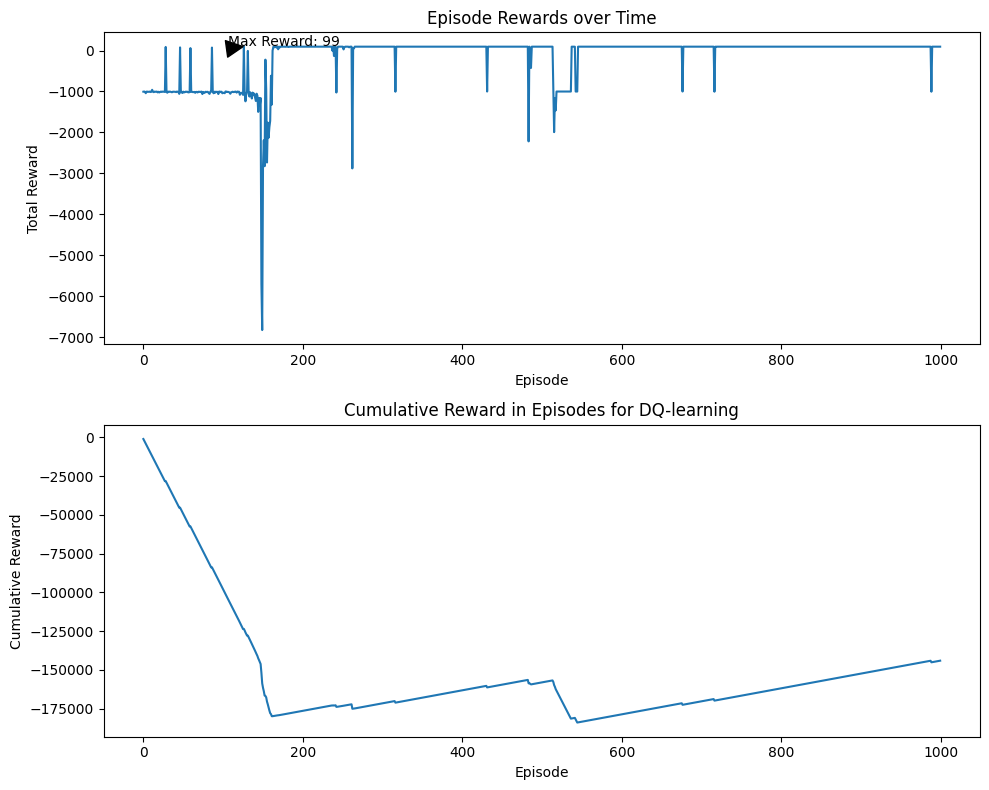

Average reward per episode after 1000 episodes: -144.024


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 2000
TAU = 0.001
LR = 0.0001
MEMORY_CAPACITY = 10000


# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


**Gamma=0.9**,

***neuron128***

Episode 1 finished after 8 steps with total reward -1007
Episode 2 finished after 10 steps with total reward -1009
Episode 3 finished after 7 steps with total reward -1006
Episode 4 finished after 5 steps with total reward -1004
Episode 5 finished after 10 steps with total reward -1009
Episode 6 finished after 8 steps with total reward -1007
Episode 7 finished after 3 steps with total reward -1002
Episode 8 finished after 5 steps with total reward -1004
Episode 9 finished after 3 steps with total reward -1002
Episode 10 finished after 6 steps with total reward -1005
Episode 11 finished after 3 steps with total reward -1002
Episode 12 finished after 6 steps with total reward -1005
Episode 13 finished after 3 steps with total reward -1002
Episode 14 finished after 4 steps with total reward -1003
Episode 15 finished after 24 steps with total reward -972
Episode 16 finished after 8 steps with total reward -1007
Episode 17 finished after 13 steps with total reward -1012
Episode 18 finished 

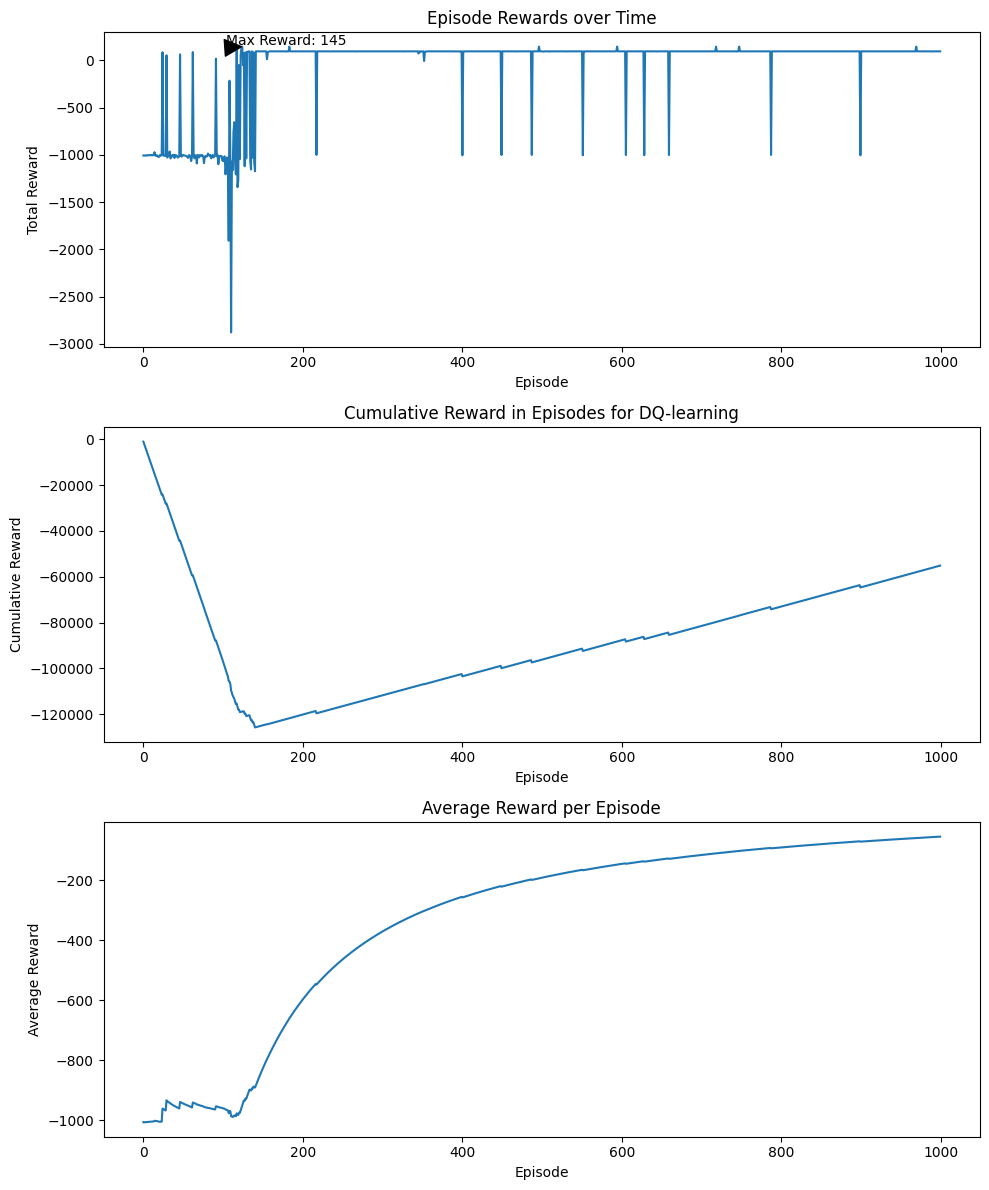

Average reward per episode after 1000 episodes: -55.117


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 2000
TAU = 0.001
LR = 0.0001
MEMORY_CAPACITY = 10000



# Main training loop

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")

**gamma=0.9 and alpha=0.01**

***neron24***

Episode 1 finished after 22 steps with total reward -1021
Episode 2 finished after 5 steps with total reward -1004
Episode 3 finished after 27 steps with total reward -1026
Episode 4 finished after 10 steps with total reward -1009
Episode 5 finished after 2 steps with total reward -1001
Episode 6 finished after 9 steps with total reward -1008
Episode 7 finished after 9 steps with total reward -1008
Episode 8 finished after 14 steps with total reward -1013
Episode 9 finished after 6 steps with total reward -1005
Episode 10 finished after 2 steps with total reward -1001
Episode 11 finished after 22 steps with total reward -1021
Episode 12 finished after 17 steps with total reward -1016
Episode 13 finished after 2 steps with total reward -1001
Episode 14 finished after 8 steps with total reward -1007
Episode 15 finished after 9 steps with total reward -957
Episode 16 finished after 8 steps with total reward -1007
Episode 17 finished after 11 steps with total reward -1010
Episode 18 finish

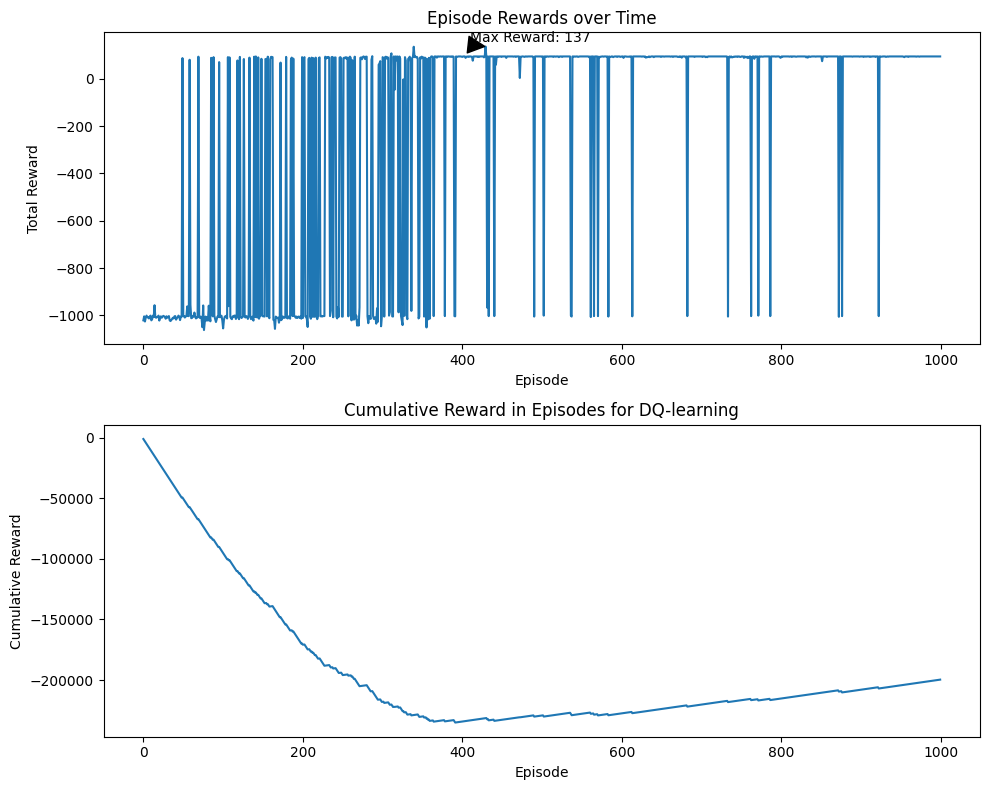

Average reward per episode after 1000 episodes: -199.661


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 2000
TAU = 0.001
LR = 0.01
MEMORY_CAPACITY = 10000


# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


***neueon128***

Episode 1 finished after 3 steps with total reward -1002
Episode 2 finished after 7 steps with total reward -1006
Episode 3 finished after 31 steps with total reward -1030
Episode 4 finished after 3 steps with total reward -1002
Episode 5 finished after 44 steps with total reward -1043
Episode 6 finished after 8 steps with total reward -1007
Episode 7 finished after 25 steps with total reward -1024
Episode 8 finished after 8 steps with total reward -1007
Episode 9 finished after 6 steps with total reward -1005
Episode 10 finished after 5 steps with total reward -1004
Episode 11 finished after 5 steps with total reward -1004
Episode 12 finished after 34 steps with total reward -1033
Episode 13 finished after 31 steps with total reward -1030
Episode 14 finished after 9 steps with total reward -1008
Episode 15 finished after 10 steps with total reward -1009
Episode 16 finished after 5 steps with total reward -1004
Episode 17 finished after 8 steps with total reward -1007
Episode 18 finish

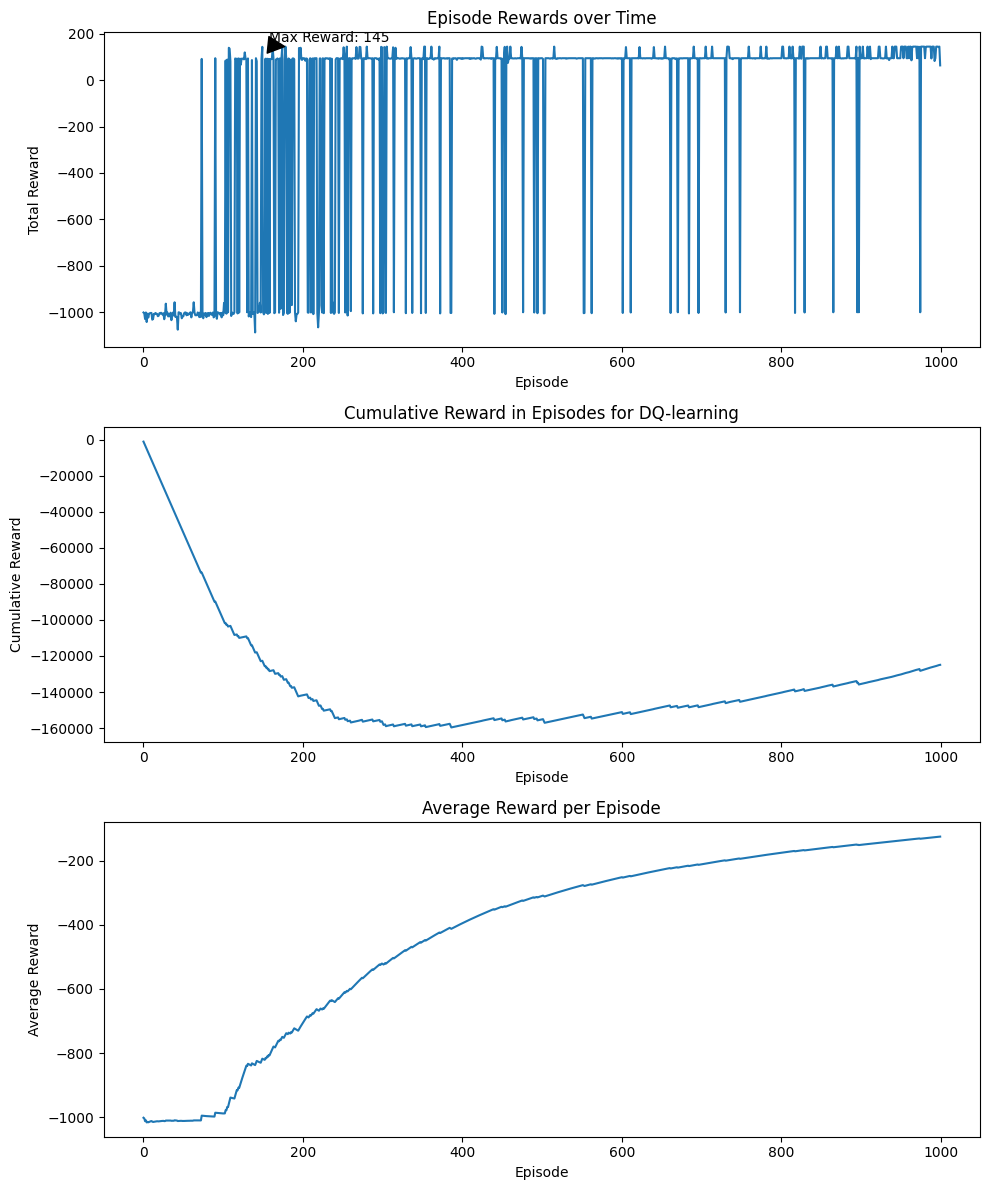

Average reward per episode after 1000 episodes: -124.922


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 2000
TAU = 0.001
LR = 0.01
MEMORY_CAPACITY = 10000



# Main training loop

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")

**learning rate=0.1**

Episode 1 finished after 3 steps with total reward -1002
Episode 2 finished after 7 steps with total reward -1006
Episode 3 finished after 5 steps with total reward -1004
Episode 4 finished after 25 steps with total reward -1024
Episode 5 finished after 29 steps with total reward -1028
Episode 6 finished after 5 steps with total reward -1004
Episode 7 finished after 3 steps with total reward -1002
Episode 8 finished after 21 steps with total reward -1020
Episode 9 finished after 47 steps with total reward 54
Episode 10 finished after 25 steps with total reward -1024
Episode 11 finished after 2 steps with total reward -1001
Episode 12 finished after 2 steps with total reward -1001
Episode 13 finished after 10 steps with total reward -1009
Episode 14 finished after 15 steps with total reward -1014
Episode 15 finished after 13 steps with total reward -1012
Episode 16 finished after 3 steps with total reward -1002
Episode 17 finished after 8 steps with total reward -1007
Episode 18 finishe

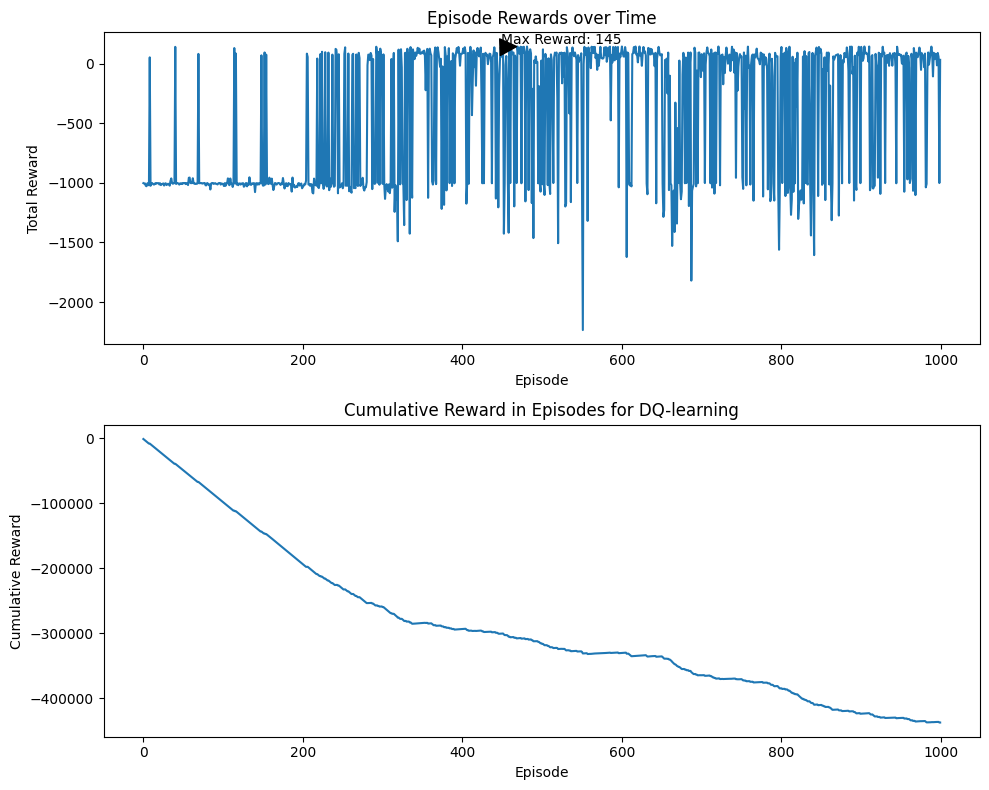

Average reward per episode after 1000 episodes: -437.3


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 2000
TAU = 0.001
LR = 0.1
MEMORY_CAPACITY = 10000


# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


#  learning rate=0.1 and gamma=0.9

***NEURON 24***

Episode 1 finished after 3 steps with total reward -1002
Episode 2 finished after 20 steps with total reward -968
Episode 3 finished after 5 steps with total reward -1004
Episode 4 finished after 16 steps with total reward -1015
Episode 5 finished after 5 steps with total reward -1004
Episode 6 finished after 2 steps with total reward -1001
Episode 7 finished after 3 steps with total reward -1002
Episode 8 finished after 20 steps with total reward -1019
Episode 9 finished after 3 steps with total reward -1002
Episode 10 finished after 17 steps with total reward -1016
Episode 11 finished after 7 steps with total reward -1006
Episode 12 finished after 3 steps with total reward -1002
Episode 13 finished after 34 steps with total reward -1033
Episode 14 finished after 7 steps with total reward -1006
Episode 15 finished after 4 steps with total reward -1003
Episode 16 finished after 3 steps with total reward -1002
Episode 17 finished after 5 steps with total reward -1004
Episode 18 finished

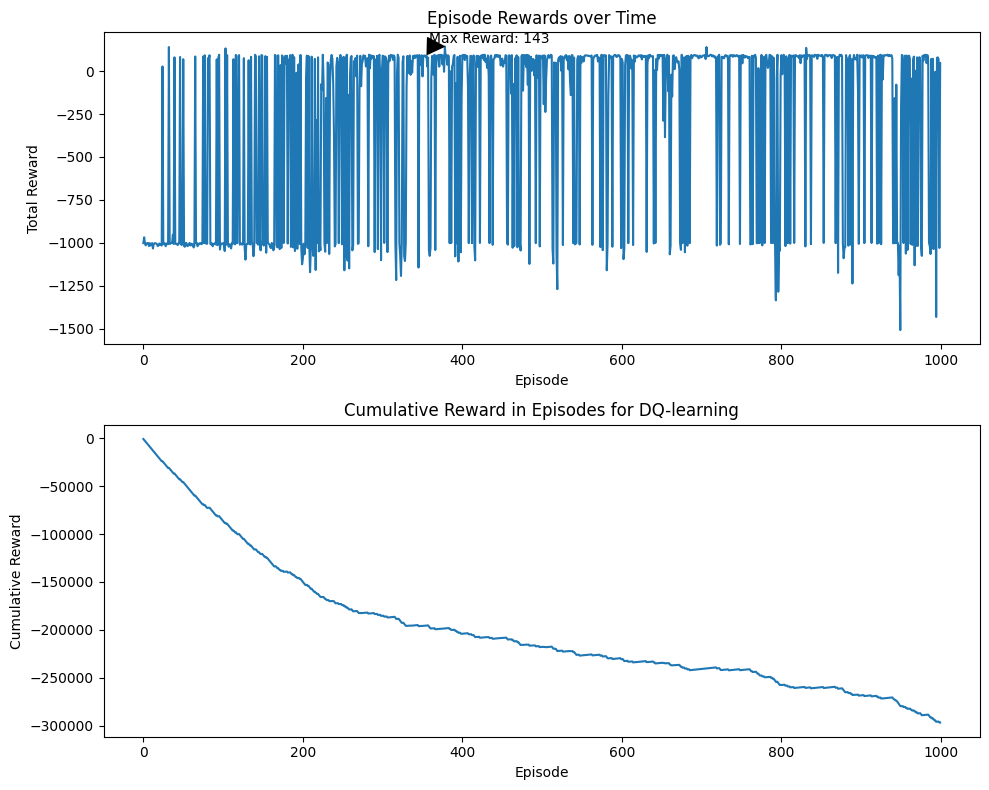

Average reward per episode after 1000 episodes: -296.438


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1000
TAU = 0.001
LR = 0.1
MEMORY_CAPACITY = 10000


# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


***NEURON 128***

Episode 1 finished after 13 steps with total reward -1012
Episode 2 finished after 9 steps with total reward -1008
Episode 3 finished after 17 steps with total reward -1016
Episode 4 finished after 4 steps with total reward -1003
Episode 5 finished after 8 steps with total reward -1007
Episode 6 finished after 8 steps with total reward -1007
Episode 7 finished after 5 steps with total reward -1004
Episode 8 finished after 14 steps with total reward -1013
Episode 9 finished after 21 steps with total reward -1020
Episode 10 finished after 2 steps with total reward -1001
Episode 11 finished after 21 steps with total reward -1020
Episode 12 finished after 6 steps with total reward -1005
Episode 13 finished after 56 steps with total reward -1004
Episode 14 finished after 11 steps with total reward -1010
Episode 15 finished after 20 steps with total reward -1019
Episode 16 finished after 25 steps with total reward -1024
Episode 17 finished after 10 steps with total reward -1009
Episode 18 fi

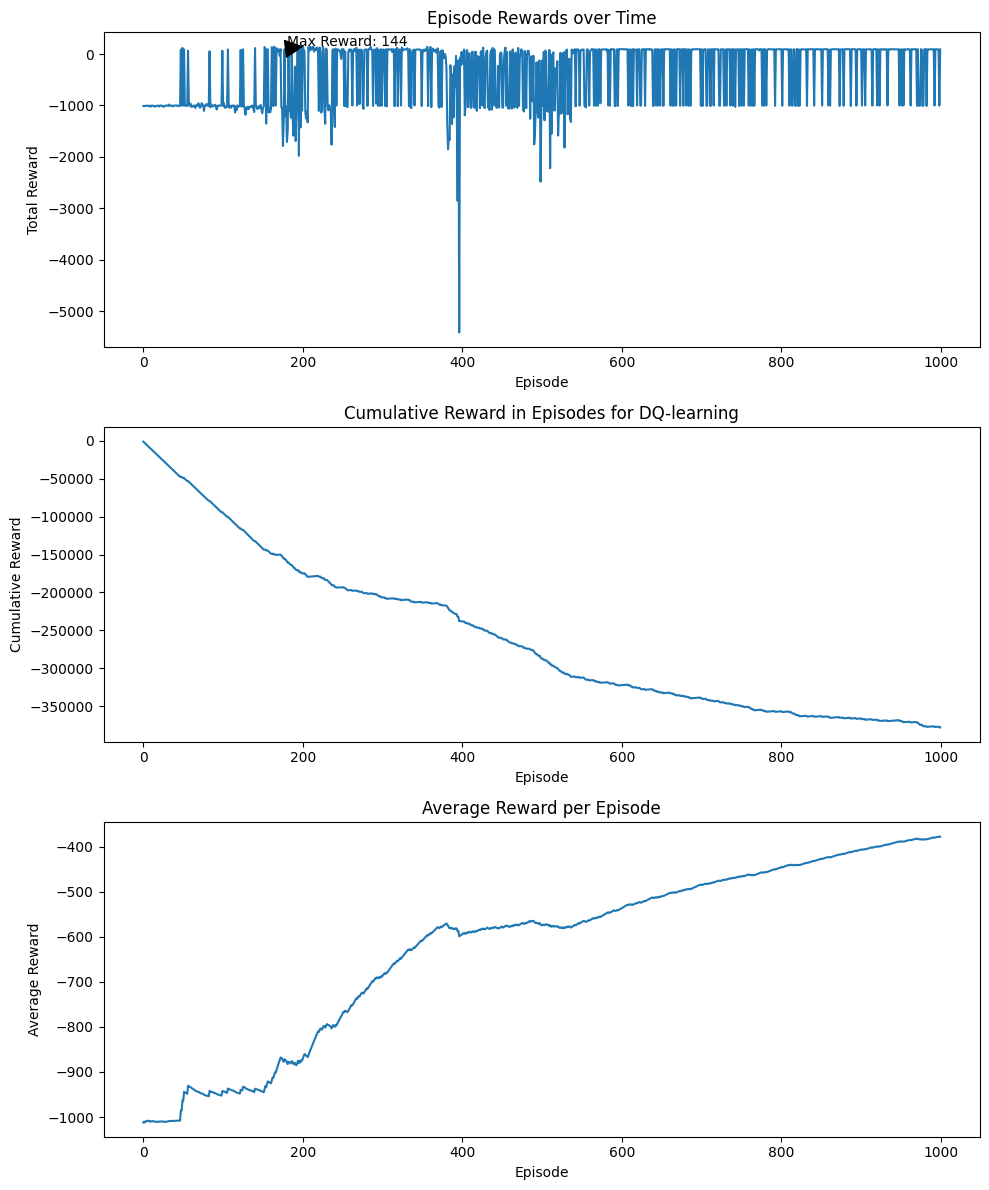

Average reward per episode after 1000 episodes: -378.034


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1000
TAU = 0.001
LR = 0.1
MEMORY_CAPACITY = 10000

if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")

# **learning raate 0.1**

***NEURON 128***

Episode 1 finished after 14 steps with total reward -1013
Episode 2 finished after 35 steps with total reward -1034
Episode 3 finished after 89 steps with total reward 12
Episode 4 finished after 29 steps with total reward -1028
Episode 5 finished after 66 steps with total reward 35
Episode 6 finished after 19 steps with total reward 82
Episode 7 finished after 8 steps with total reward 93
Episode 8 finished after 10 steps with total reward 91
Episode 9 finished after 9 steps with total reward 92
Episode 10 finished after 4 steps with total reward -1003
Episode 11 finished after 2 steps with total reward -1001
Episode 12 finished after 19 steps with total reward 133
Episode 13 finished after 8 steps with total reward 93
Episode 14 finished after 8 steps with total reward 93
Episode 15 finished after 9 steps with total reward 92
Episode 16 finished after 10 steps with total reward 91
Episode 17 finished after 9 steps with total reward 92
Episode 18 finished after 10 steps with total rew

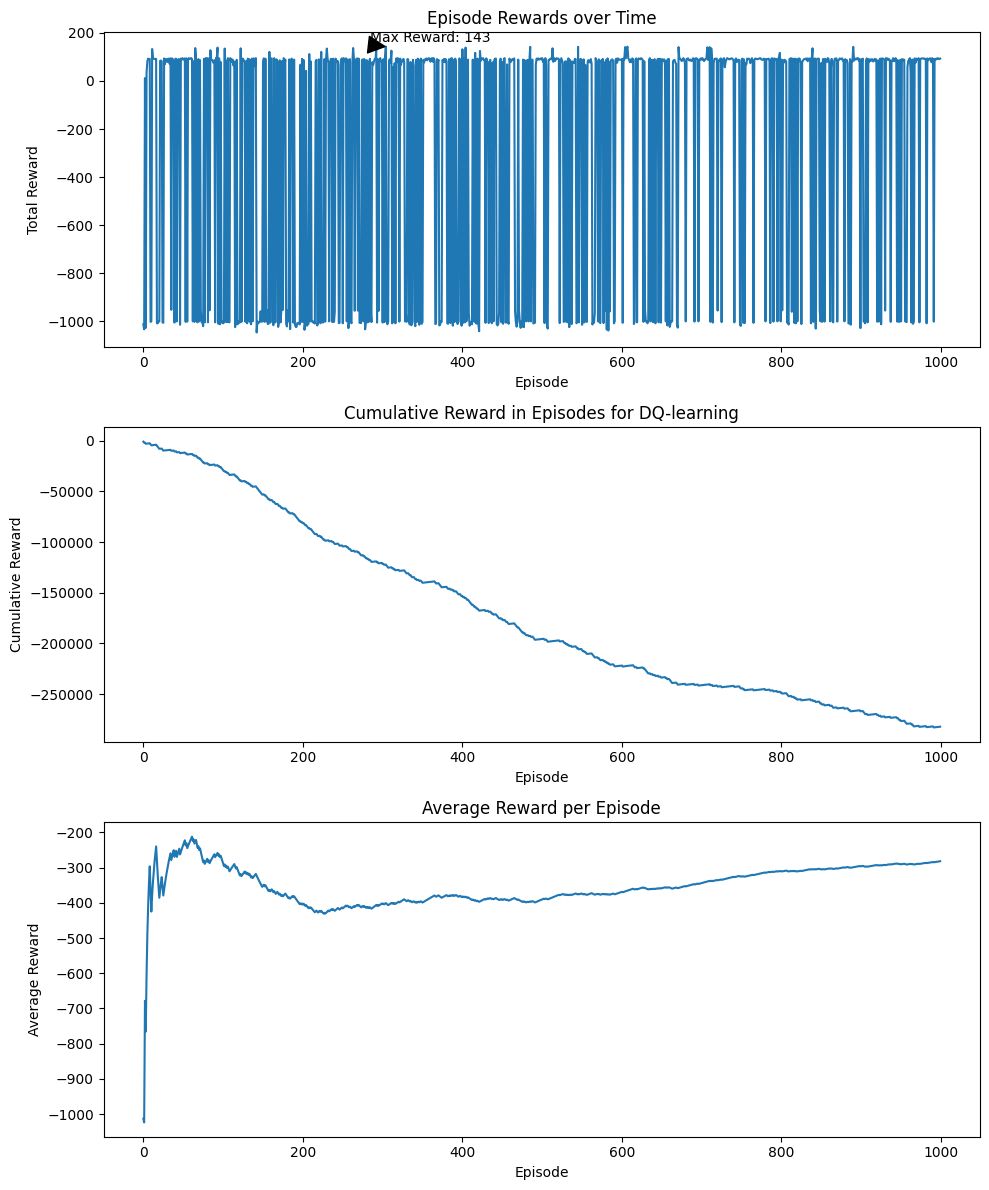

Average reward per episode after 1000 episodes: -282.023


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 100
TAU = 0.001
LR = 0.1
MEMORY_CAPACITY = 10000# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")

***24 neuron***

Episode 1 finished after 15 steps with total reward -1014
Episode 2 finished after 33 steps with total reward -1032
Episode 3 finished after 50 steps with total reward 51
Episode 4 finished after 32 steps with total reward 69
Episode 5 finished after 2 steps with total reward -1001
Episode 6 finished after 7 steps with total reward -1006
Episode 7 finished after 13 steps with total reward -1012
Episode 8 finished after 32 steps with total reward -1031
Episode 9 finished after 33 steps with total reward 119
Episode 10 finished after 78 steps with total reward -1077
Episode 11 finished after 12 steps with total reward -1011
Episode 12 finished after 250 steps with total reward -1249
Episode 13 finished after 694 steps with total reward -1693
Episode 14 finished after 305 steps with total reward -1304
Episode 15 finished after 356 steps with total reward -255
Episode 16 finished after 29 steps with total reward -1028
Episode 17 finished after 95 steps with total reward -1094
Episode 18 fi

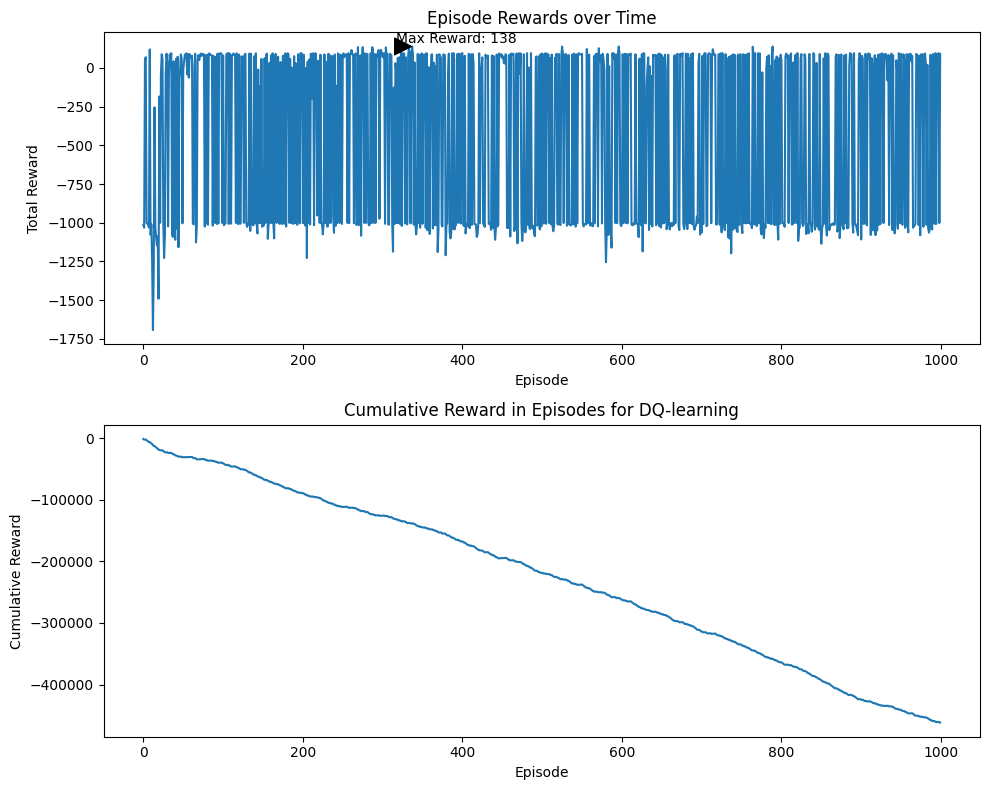

Average reward per episode after 1000 episodes: -461.702


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 100
TAU = 0.001
LR = 0.1
MEMORY_CAPACITY = 10000


# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


***NORMALIZATION***

Episode 1 finished after 25 steps with total reward -0.10240000142948702
Episode 2 finished after 5 steps with total reward -0.10040000148001127
Episode 3 finished after 8 steps with total reward -0.10070000147243263
Episode 4 finished after 60 steps with total reward -0.10590000134106958
Episode 5 finished after 26 steps with total reward -0.10250000142696081
Episode 6 finished after 33 steps with total reward -0.10320000140927732
Episode 7 finished after 5 steps with total reward -0.10040000148001127
Episode 8 finished after 14 steps with total reward -0.10130000145727536
Episode 9 finished after 17 steps with total reward -0.10160000144969672
Episode 10 finished after 5 steps with total reward -0.10040000148001127
Episode 11 finished after 9 steps with total reward -0.10080000146990642
Episode 12 finished after 432 steps with total reward -0.03309999913471984
Episode 13 finished after 20 steps with total reward -0.10190000144211808
Episode 14 finished after 258 steps with total rewa

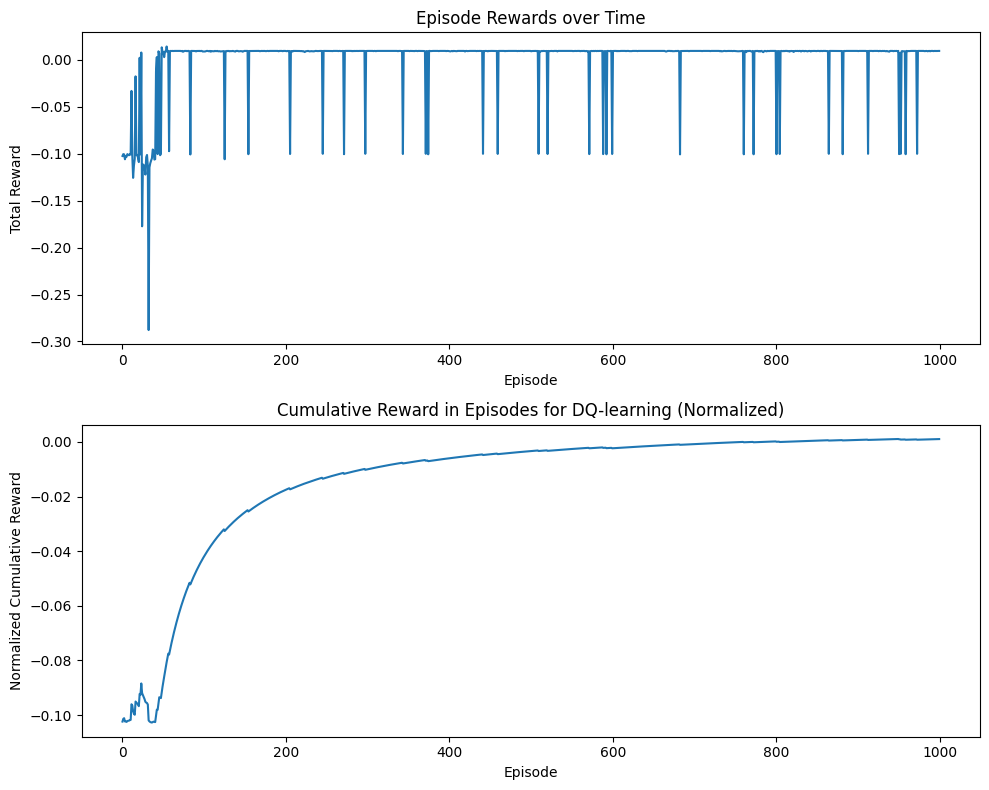

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        # Normalize reward
        reward /= 100.0  # Normalizing all rewards by dividing by 100.0
        reward = torch.tensor([reward], device=device, dtype=torch.float32)  # Ensure reward is tensor
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward / 100.0], device=device, dtype=torch.float32)  # Normalize reward

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards


# Hyperparameters
BATCH_SIZE = 64
GAMMA = 0.9
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TAU = 0.01
LR = 0.0001
MEMORY_CAPACITY = 10000

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards = agent.learn(num_episodes)

    # Normalize cumulative rewards
    normalized_rewards = [sum(episode_rewards[:i+1]) / (i + 1) for i in range(len(episode_rewards))]

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(normalized_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning (Normalized)')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Normalized Cumulative Reward')

    plt.tight_layout()
    plt.show()


# **قسمت ج**

**epsilon decay**=200



***neuron 24***

Episode 1 finished after 11 steps with total reward -1010
Episode 2 finished after 60 steps with total reward -1059
Episode 3 finished after 27 steps with total reward -1026
Episode 4 finished after 9 steps with total reward 92
Episode 5 finished after 22 steps with total reward -970
Episode 6 finished after 51 steps with total reward -1050
Episode 7 finished after 16 steps with total reward -964
Episode 8 finished after 2 steps with total reward -1001
Episode 9 finished after 21 steps with total reward -969
Episode 10 finished after 34 steps with total reward -982
Episode 11 finished after 9 steps with total reward -1008
Episode 12 finished after 164 steps with total reward -1112
Episode 13 finished after 107 steps with total reward -1106
Episode 14 finished after 450 steps with total reward -1398
Episode 15 finished after 773 steps with total reward -1721
Episode 16 finished after 169 steps with total reward -1168
Episode 17 finished after 2461 steps with total reward -3409
Episode 1

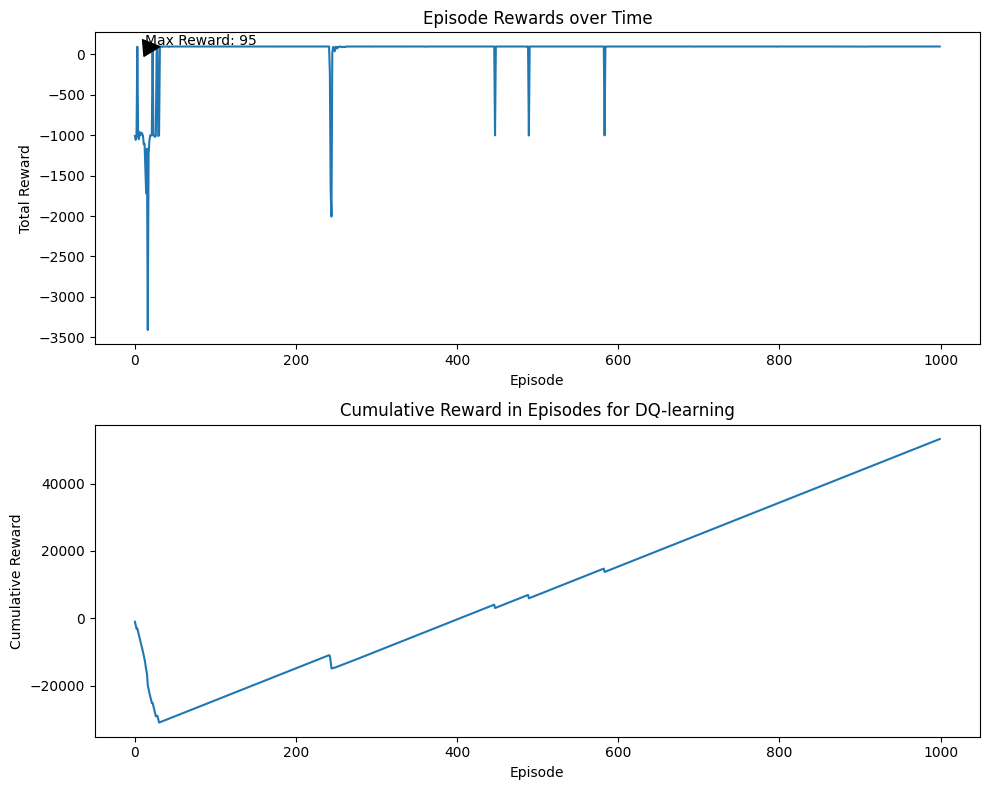

Average reward per episode after 1000 episodes: 53.266


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 200
TAU = 0.001
LR = 0.001
MEMORY_CAPACITY = 10000


# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


**epsilon decay**=200


***neuron 128***

Episode 1 finished after 9 steps with total reward -1008
Episode 2 finished after 20 steps with total reward -1019
Episode 3 finished after 23 steps with total reward -1022
Episode 4 finished after 25 steps with total reward -1024
Episode 5 finished after 6 steps with total reward -1005
Episode 6 finished after 8 steps with total reward -1007
Episode 7 finished after 3 steps with total reward -1002
Episode 8 finished after 35 steps with total reward -1034
Episode 9 finished after 13 steps with total reward -1012
Episode 10 finished after 5 steps with total reward -1004
Episode 11 finished after 24 steps with total reward -1023
Episode 12 finished after 34 steps with total reward -1033
Episode 13 finished after 20 steps with total reward -1019
Episode 14 finished after 33 steps with total reward -1032
Episode 15 finished after 41 steps with total reward -1040
Episode 16 finished after 183 steps with total reward -1182
Episode 17 finished after 240 steps with total reward -1239
Episode 1

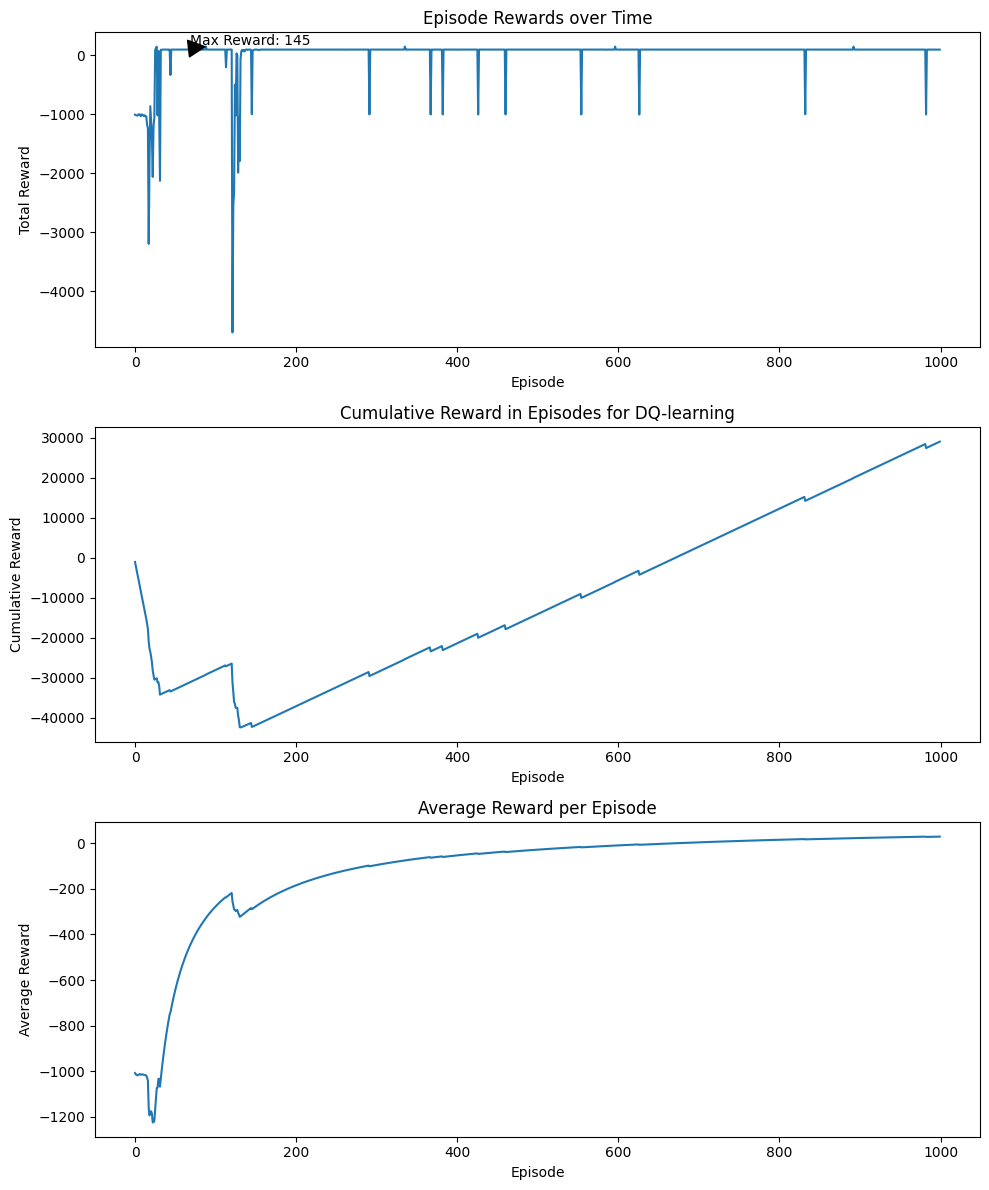

Average reward per episode after 1000 episodes: 29.059


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 200
TAU = 0.001
LR = 0.001
MEMORY_CAPACITY = 10000


# Main training loop

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


**EPS_DECAY** = 800


**neuron24**

Episode 1 finished after 3 steps with total reward -1002
Episode 2 finished after 4 steps with total reward -1003
Episode 3 finished after 7 steps with total reward -1006
Episode 4 finished after 6 steps with total reward -1005
Episode 5 finished after 4 steps with total reward -1003
Episode 6 finished after 5 steps with total reward -1004
Episode 7 finished after 7 steps with total reward -1006
Episode 8 finished after 3 steps with total reward -1002
Episode 9 finished after 8 steps with total reward -1007
Episode 10 finished after 5 steps with total reward -1004
Episode 11 finished after 2 steps with total reward -1001
Episode 12 finished after 2 steps with total reward -1001
Episode 13 finished after 9 steps with total reward -1008
Episode 14 finished after 3 steps with total reward -1002
Episode 15 finished after 6 steps with total reward -1005
Episode 16 finished after 6 steps with total reward -1005
Episode 17 finished after 15 steps with total reward -963
Episode 18 finished aft

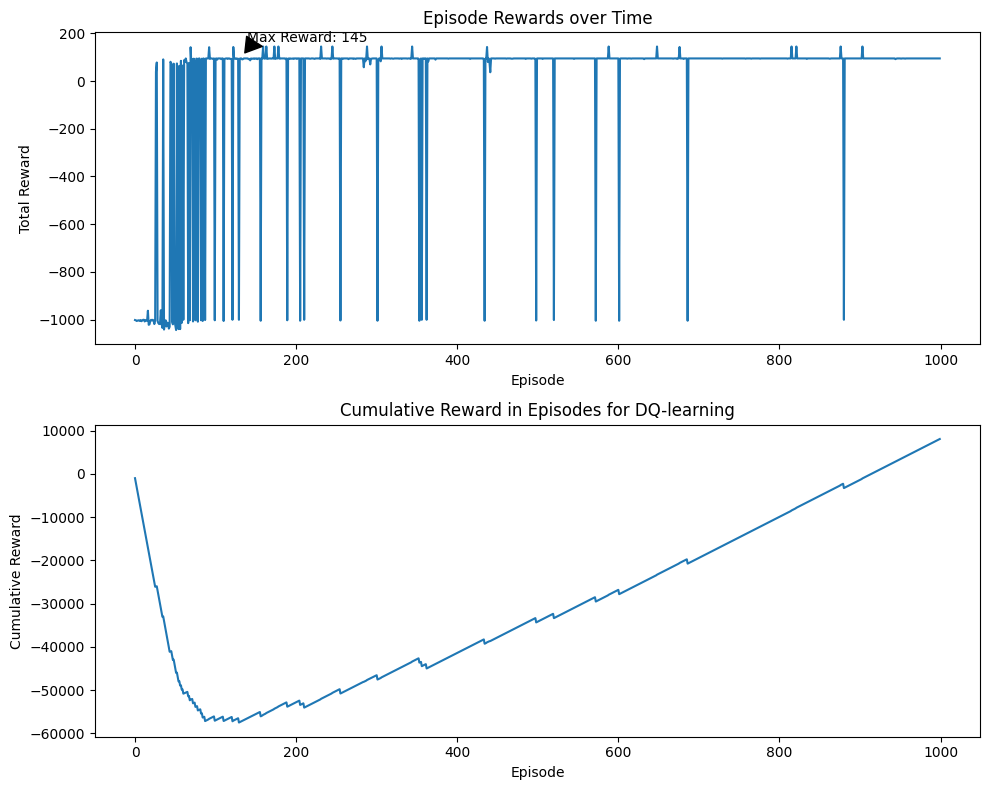

Average reward per episode after 1000 episodes: 8.06


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 800
TAU = 0.001
LR = 0.001
MEMORY_CAPACITY = 10000


# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


**EPS_DECAY** = 800  

***neuron 128***

Episode 1 finished after 7 steps with total reward -1006
Episode 2 finished after 2 steps with total reward -1001
Episode 3 finished after 8 steps with total reward -1007
Episode 4 finished after 8 steps with total reward -956
Episode 5 finished after 9 steps with total reward -1008
Episode 6 finished after 8 steps with total reward -1007
Episode 7 finished after 4 steps with total reward -1003
Episode 8 finished after 2 steps with total reward -1001
Episode 9 finished after 3 steps with total reward -1002
Episode 10 finished after 6 steps with total reward -1005
Episode 11 finished after 7 steps with total reward -1006
Episode 12 finished after 7 steps with total reward -1006
Episode 13 finished after 2 steps with total reward -1001
Episode 14 finished after 19 steps with total reward -1018
Episode 15 finished after 7 steps with total reward -1006
Episode 16 finished after 13 steps with total reward -1012
Episode 17 finished after 11 steps with total reward -1010
Episode 18 finished a

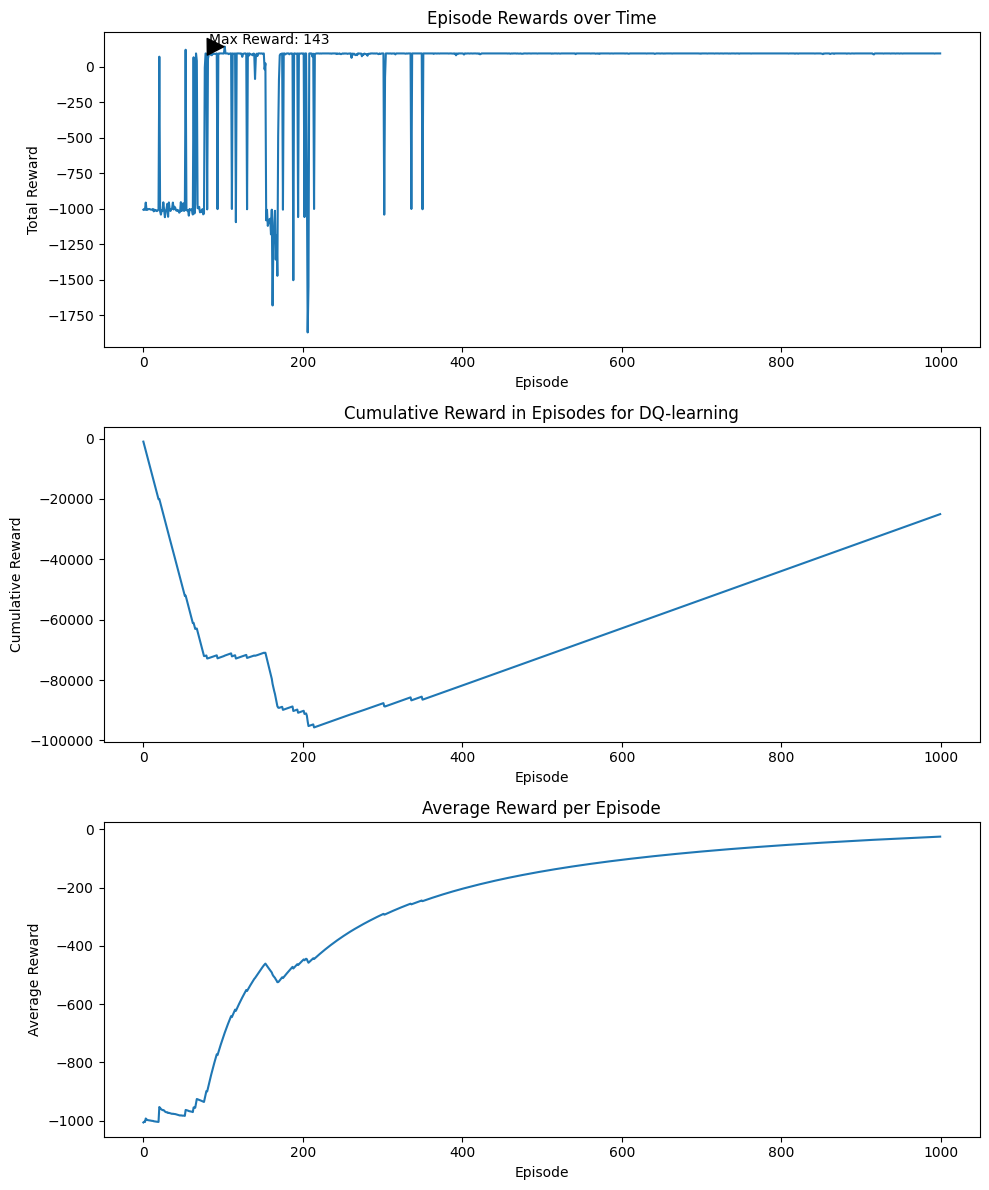

Average reward per episode after 1000 episodes: -25.029


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 800
TAU = 0.001
LR = 0.001
MEMORY_CAPACITY = 10000


# Main training loop

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")

**EPS_DECAY** = 800


***neuron 24***

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 800
TAU = 0.001
LR = 0.001
MEMORY_CAPACITY = 10000


# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


Episode 1 finished after 9 steps with total reward -1008
Episode 2 finished after 8 steps with total reward -1007
Episode 3 finished after 12 steps with total reward 89
Episode 4 finished after 5 steps with total reward -1004
Episode 5 finished after 3 steps with total reward -1002
Episode 6 finished after 11 steps with total reward -959
Episode 7 finished after 24 steps with total reward 77
Episode 8 finished after 16 steps with total reward -1015
Episode 9 finished after 3 steps with total reward -1002
Episode 10 finished after 18 steps with total reward -1017
Episode 11 finished after 7 steps with total reward -1006
Episode 12 finished after 4 steps with total reward -1003
Episode 13 finished after 16 steps with total reward -1015
Episode 14 finished after 4 steps with total reward -1003
Episode 15 finished after 2 steps with total reward -1001
Episode 16 finished after 14 steps with total reward -1013
Episode 17 finished after 15 steps with total reward -1014
Episode 18 finished af

Average reward per episode after 1000 episodes: 19.414


# **ج پارامترهای سوال**

**BATCH_SIZE** = 64
**LR**=0.1

***neuron*** 128


Episode 1 finished after 3 steps with total reward -1002
Episode 2 finished after 5 steps with total reward -1004
Episode 3 finished after 6 steps with total reward -1005
Episode 4 finished after 6 steps with total reward -1005
Episode 5 finished after 26 steps with total reward -1025
Episode 6 finished after 15 steps with total reward -1014
Episode 7 finished after 8 steps with total reward -1007
Episode 8 finished after 28 steps with total reward -976
Episode 9 finished after 83 steps with total reward -1082
Episode 10 finished after 100 steps with total reward -1099
Episode 11 finished after 12 steps with total reward -1011
Episode 12 finished after 5 steps with total reward -1004
Episode 13 finished after 60 steps with total reward -1059
Episode 14 finished after 48 steps with total reward -996
Episode 15 finished after 18 steps with total reward -1017
Episode 16 finished after 19 steps with total reward -1018
Episode 17 finished after 79 steps with total reward 73
Episode 18 finis

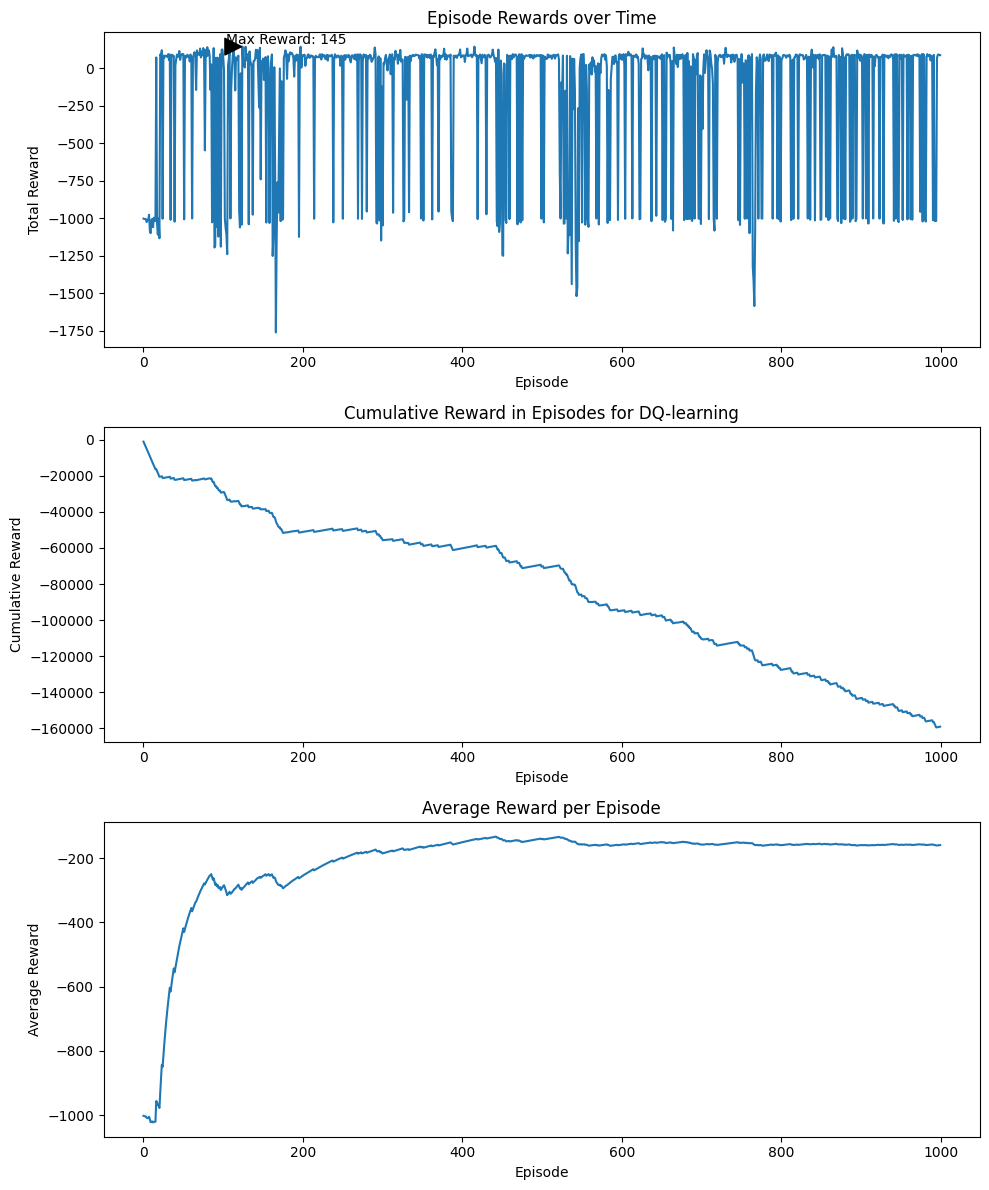

Average reward per episode after 1000 episodes: -159.129


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 64
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 200
TAU = 0.001
LR = 0.1
MEMORY_CAPACITY = 10000


# Main training loop

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")

**BATCH_SIZE** = 64
**LR**=0.1

***neuron*** 24


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 64
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 200
TAU = 0.001
LR = 0.1
MEMORY_CAPACITY = 10000


# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


Episode 1 finished after 4 steps with total reward -1003
Episode 2 finished after 12 steps with total reward -1011
Episode 3 finished after 3 steps with total reward -1002
Episode 4 finished after 16 steps with total reward -1015
Episode 5 finished after 2 steps with total reward -1001
Episode 6 finished after 8 steps with total reward -1007
Episode 7 finished after 3 steps with total reward -1002
Episode 8 finished after 14 steps with total reward 138
Episode 9 finished after 4 steps with total reward -1003
Episode 10 finished after 5 steps with total reward -1004
Episode 11 finished after 45 steps with total reward -1044
Episode 12 finished after 6 steps with total reward -1005
Episode 13 finished after 4 steps with total reward -1003
Episode 14 finished after 4 steps with total reward -1003
Episode 15 finished after 2 steps with total reward -1001
Episode 16 finished after 4 steps with total reward -1003
Episode 17 finished after 2 steps with total reward -1001
Episode 18 finished a

Average reward per episode after 1000 episodes: -314.81


**BATCH_SIZE** = 128


***neuron*** 128


Episode 1 finished after 31 steps with total reward -1030
Episode 2 finished after 14 steps with total reward -1013
Episode 3 finished after 31 steps with total reward -1030
Episode 4 finished after 51 steps with total reward -1050
Episode 5 finished after 9 steps with total reward -1008
Episode 6 finished after 2 steps with total reward -1001
Episode 7 finished after 7 steps with total reward -1006
Episode 8 finished after 8 steps with total reward -1007
Episode 9 finished after 2 steps with total reward -1001
Episode 10 finished after 4 steps with total reward -1003
Episode 11 finished after 6 steps with total reward -1005
Episode 12 finished after 30 steps with total reward -1029
Episode 13 finished after 34 steps with total reward 67
Episode 14 finished after 27 steps with total reward -1026
Episode 15 finished after 60 steps with total reward -1059
Episode 16 finished after 202 steps with total reward -1201
Episode 17 finished after 370 steps with total reward -1369
Episode 18 fin

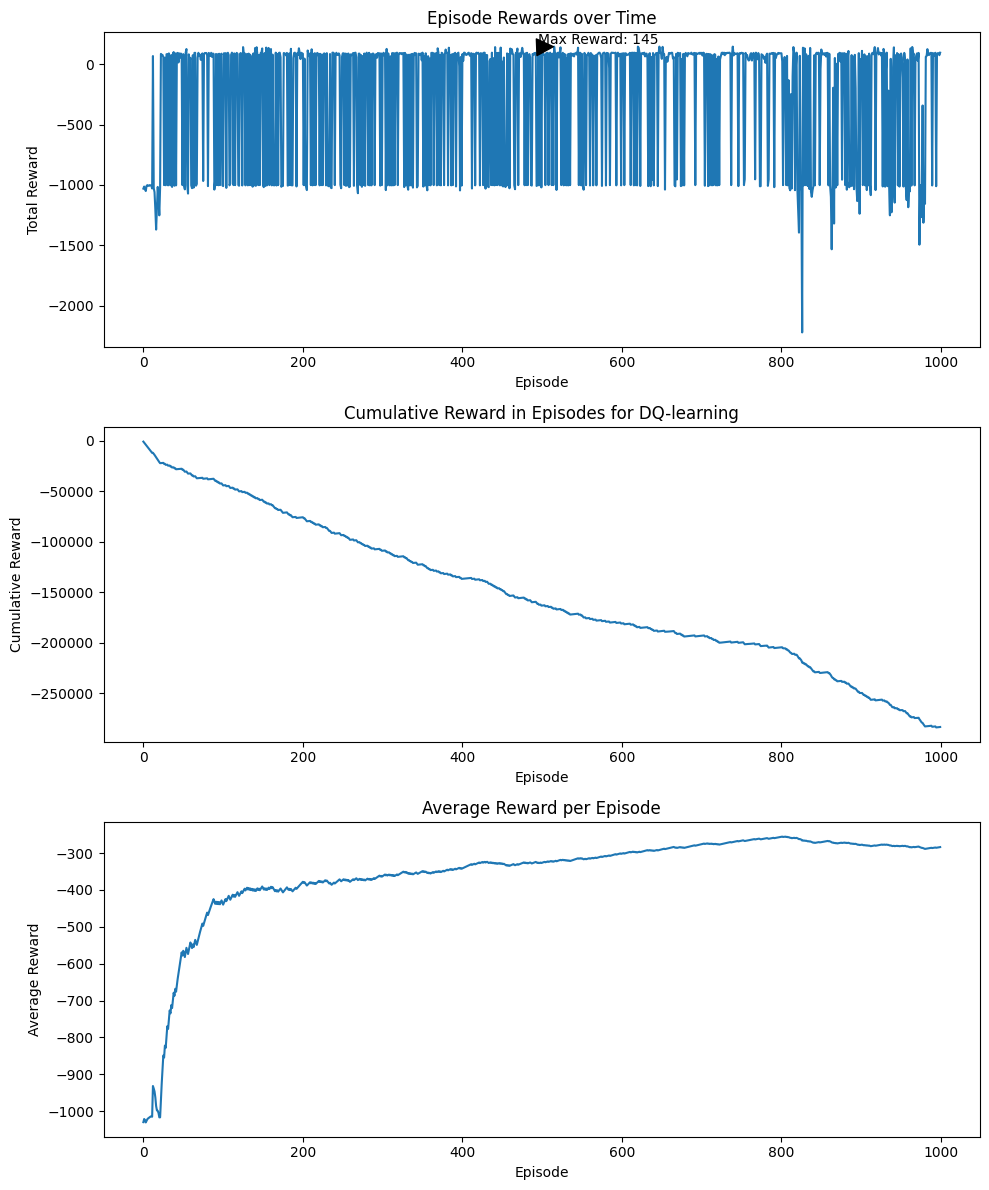

Average reward per episode after 1000 episodes: -283.659


In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 200
TAU = 0.001
LR = 0.1
MEMORY_CAPACITY = 10000


# Main training loop

# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")

# ساختار شبکه

In [ ]:
!pip install torchviz


  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [ ]:

import torch
from torchviz import make_dot

# Create a sample input tensor
sample_input = torch.randn(1, env.size * env.size).to(device)
# Pass through the policy network
policy_net = agent.policy_net
output = policy_net(sample_input)

# Generate a visualization of the model
dot = make_dot(output, params=dict(policy_net.named_parameters()))
dot.render('DQN_Model', format='png', cleanup=True)
from PIL import Image

# Open the saved image
img = Image.open('DQN_Model.png')

# Show the image
img.show()


In [ ]:
# Accessing model parameters
for name, param in agent.policy_net.named_parameters():
    print(f"Layer: {name} - Size: {param.size()} - Values: {param.data}")
from torchsummary import summary

# Print model summary
summary(agent.policy_net, input_size=(1, env.size * env.size))


Layer: fc1.weight - Size: torch.Size([128, 16]) - Values: tensor([[-0.0133,  0.1472,  0.2266,  ...,  0.1530,  0.1683, -0.1819],
        [-0.2700, -0.4183,  0.9390,  ..., -0.4548, -0.4610, -0.2304],
        [-0.1132,  0.2018, -0.2000,  ...,  0.1815, -0.2223, -0.0171],
        ...,
        [-0.2215, -0.3562,  0.7601,  ..., -0.1204, -0.4297, -0.5714],
        [-2.5598, -2.8326, -2.2850,  ..., -2.7181, -2.8290, -2.2974],
        [-0.0910,  0.1368, -2.6183,  ...,  0.0722, -0.0992, -2.5906]])
Layer: fc1.bias - Size: torch.Size([128]) - Values: tensor([-0.1614, -0.2368, -0.0251, -2.5836, -0.5489,  0.0053, -0.7914, -0.3983,
        -0.2234, -0.4933, -0.9754, -2.5699, -2.6644, -0.6296, -0.5961, -2.7153,
        -2.2738, -0.6522, -0.4084, -0.5253, -0.5289, -0.1639, -0.5688, -0.5504,
        -0.6042, -0.5426, -0.6815, -0.0674, -0.6419, -0.4786, -0.8049, -0.6221,
        -0.4991, -0.6081, -0.7695, -0.6951, -0.6173, -0.7133, -2.5788, -0.6556,
         0.2072, -0.5914, -2.2581, -0.6541, -0.5088, -0.

# **Q-learning**

Q-learning Episode 1/1000, Total Reward: -1011
Q-learning Episode 2/1000, Total Reward: -1003
Q-learning Episode 3/1000, Total Reward: -1013
Q-learning Episode 4/1000, Total Reward: -1007
Q-learning Episode 5/1000, Total Reward: -1008
Q-learning Episode 6/1000, Total Reward: -1003
Q-learning Episode 7/1000, Total Reward: -1002
Q-learning Episode 8/1000, Total Reward: -1010
Q-learning Episode 9/1000, Total Reward: -1018
Q-learning Episode 10/1000, Total Reward: -1001
Q-learning Episode 11/1000, Total Reward: -1016
Q-learning Episode 12/1000, Total Reward: -1016
Q-learning Episode 13/1000, Total Reward: -1002
Q-learning Episode 14/1000, Total Reward: -1010
Q-learning Episode 15/1000, Total Reward: -1003
Q-learning Episode 16/1000, Total Reward: -1002
Q-learning Episode 17/1000, Total Reward: -1006
Q-learning Episode 18/1000, Total Reward: -1002
Q-learning Episode 19/1000, Total Reward: -1010
Q-learning Episode 20/1000, Total Reward: -1005
Q-learning Episode 21/1000, Total Reward: -1005
Q

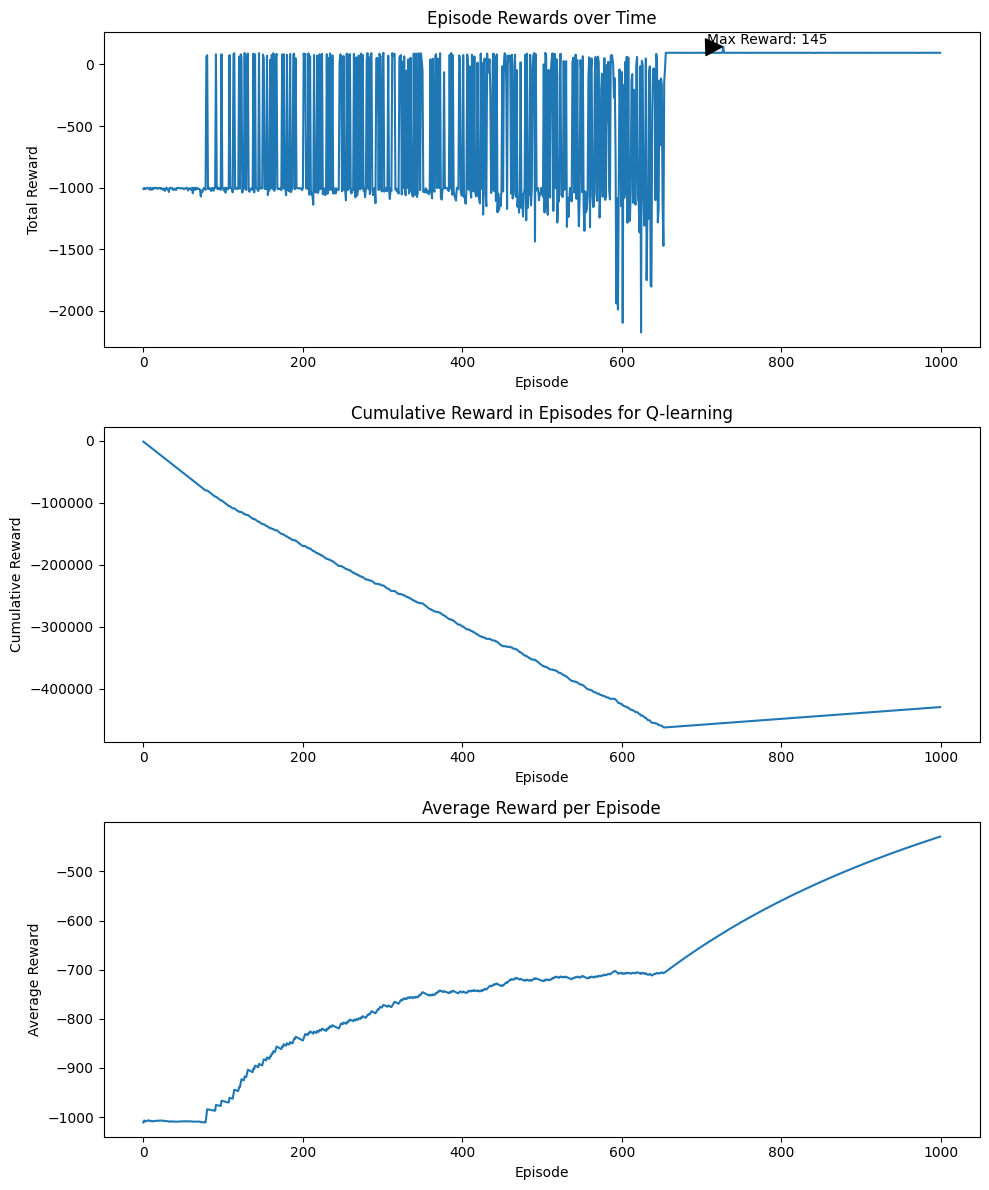

Average reward per episode after 1000 episodes: -429.221
First episode where agent consistently finds gold for consecutive episodes: 656


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class WumpusWorld:
    def __init__(self, size=4):
        self.size = size
        self.reset()

    def reset(self):
        self.agent_pos = (0, 0)
        self.gold_pos = (self.size - 1, self.size - 1)
        self.pits = {(1, 1), (2, 2), (3, 0)}
        self.wumpus_pos = (3, 3)
        self.is_wumpus_alive = True
        self.has_arrow = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1  # Agent position
        state[self.gold_pos] = 2  # Gold position
        for pit in self.pits:
            state[pit] = 3  # Pit positions
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 4  # Wumpus position
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1  # Small penalty for each step to encourage shorter paths
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)
        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

class Agent:
    def __init__(self, state_size, action_size, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        return np.argmax(self.q_table[state])

    def learn(self, num_episodes):
        episode_rewards = []
        consecutive_successful_episodes = 0
        first_consistent_episode = None

        for episode in range(1, num_episodes + 1):
            state = env.reset()
            state_idx = self._state_to_index(state)
            total_reward = 0
            done = False
            steps = 0

            while not done:
                action = self.choose_action(state_idx)
                next_state, reward, done = env.step(action)
                next_state_idx = self._state_to_index(next_state)

                self.q_table[state_idx, action] = (1 - self.alpha) * self.q_table[state_idx, action] + \
                    self.alpha * (reward + self.gamma * np.max(self.q_table[next_state_idx]))

                state_idx = next_state_idx
                total_reward += reward
                steps += 1

            episode_rewards.append(total_reward)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            # Check for consistent episodes with reward 95
            if total_reward == 95:
                consecutive_successful_episodes += 1
                if consecutive_successful_episodes == 10 and first_consistent_episode is None:
                    first_consistent_episode = episode - 9
            else:
                consecutive_successful_episodes = 0

            print(f"Q-learning Episode {episode}/{num_episodes}, Total Reward: {total_reward}")

        return episode_rewards, first_consistent_episode

    def _state_to_index(self, state):
        return hash(tuple(state)) % self.state_size

if __name__ == "__main__":
    env = WumpusWorld()
    env_size = env.size  # Size of the environment grid
    num_actions = 5  # 4 movement actions + 1 shoot action
    ALPHA = 0.1  # Learning rate
    GAMMA = 0.9  # Discount factor
    EPSILON = 0.9  # Initial epsilon for epsilon-greedy exploration
    EPSILON_DECAY = 0.995  # Epsilon decay rate
    EPSILON_MIN = 0.01  # Minimum epsilon
    NUM_EPISODES = 1000  # Number of episodes to run

    agent = Agent(env_size * env_size, num_actions, ALPHA, GAMMA, EPSILON, EPSILON_DECAY, EPSILON_MIN)

    episode_rewards, first_consistent_episode = agent.learn(NUM_EPISODES)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Calculate cumulative rewards
    cumulative_rewards = np.cumsum(episode_rewards)
    # Calculate maximum reward achieved
    max_reward = np.max(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for Q-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {NUM_EPISODES} episodes: {avg_reward_per_episode}")
    print(f"First episode where agent consistently finds gold for consecutive episodes: {first_consistent_episode}")


**QL-EPSOLON** =0.8

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class WumpusWorld:
    def __init__(self, size=4):
        self.size = size
        self.reset()

    def reset(self):
        self.agent_pos = (0, 0)
        self.gold_pos = (self.size - 1, self.size - 1)
        self.pits = {(1, 1), (2, 2), (3, 0)}
        self.wumpus_pos = (3, 3)
        self.is_wumpus_alive = True
        self.has_arrow = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1  # Agent position
        state[self.gold_pos] = 2  # Gold position
        for pit in self.pits:
            state[pit] = 3  # Pit positions
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 4  # Wumpus position
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1  # Small penalty for each step to encourage shorter paths
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)
        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

class Agent:
    def __init__(self, state_size, action_size, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        return np.argmax(self.q_table[state])

    def learn(self, num_episodes):
        episode_rewards = []
        consecutive_successful_episodes = 0
        first_consistent_episode = None

        for episode in range(1, num_episodes + 1):
            state = env.reset()
            state_idx = self._state_to_index(state)
            total_reward = 0
            done = False
            steps = 0

            while not done:
                action = self.choose_action(state_idx)
                next_state, reward, done = env.step(action)
                next_state_idx = self._state_to_index(next_state)

                self.q_table[state_idx, action] = (1 - self.alpha) * self.q_table[state_idx, action] + \
                    self.alpha * (reward + self.gamma * np.max(self.q_table[next_state_idx]))

                state_idx = next_state_idx
                total_reward += reward
                steps += 1

            episode_rewards.append(total_reward)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            # Check for consistent episodes with reward 95
            if total_reward == 95:
                consecutive_successful_episodes += 1
                if consecutive_successful_episodes == 10 and first_consistent_episode is None:
                    first_consistent_episode = episode - 9
            else:
                consecutive_successful_episodes = 0

            print(f"Q-learning Episode {episode}/{num_episodes}, Total Reward: {total_reward}")

        return episode_rewards, first_consistent_episode

    def _state_to_index(self, state):
        return hash(tuple(state)) % self.state_size

if __name__ == "__main__":
    env = WumpusWorld()
    env_size = env.size  # Size of the environment grid
    num_actions = 5  # 4 movement actions + 1 shoot action
    ALPHA = 0.1  # Learning rate
    GAMMA = 0.9  # Discount factor
    EPSILON = 0.8  # Initial epsilon for epsilon-greedy exploration
    EPSILON_DECAY = 0.995  # Epsilon decay rate
    EPSILON_MIN = 0.01  # Minimum epsilon
    NUM_EPISODES = 1000  # Number of episodes to run

    agent = Agent(env_size * env_size, num_actions, ALPHA, GAMMA, EPSILON, EPSILON_DECAY, EPSILON_MIN)

    episode_rewards, first_consistent_episode = agent.learn(NUM_EPISODES)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Calculate cumulative rewards
    cumulative_rewards = np.cumsum(episode_rewards)
    # Calculate maximum reward achieved
    max_reward = np.max(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for Q-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {NUM_EPISODES} episodes: {avg_reward_per_episode}")
    print(f"First episode where agent consistently finds gold for consecutive episodes: {first_consistent_episode}")


Q-learning Episode 1/1000, Total Reward: -1011
Q-learning Episode 2/1000, Total Reward: -1003
Q-learning Episode 3/1000, Total Reward: -1016
Q-learning Episode 4/1000, Total Reward: -1003
Q-learning Episode 5/1000, Total Reward: -1007
Q-learning Episode 6/1000, Total Reward: -1006
Q-learning Episode 7/1000, Total Reward: -1026
Q-learning Episode 8/1000, Total Reward: -1009
Q-learning Episode 9/1000, Total Reward: -1001
Q-learning Episode 10/1000, Total Reward: -1006
Q-learning Episode 11/1000, Total Reward: -1016
Q-learning Episode 12/1000, Total Reward: -1009
Q-learning Episode 13/1000, Total Reward: -1009
Q-learning Episode 14/1000, Total Reward: -1003
Q-learning Episode 15/1000, Total Reward: -1008
Q-learning Episode 16/1000, Total Reward: -1002
Q-learning Episode 17/1000, Total Reward: -1008
Q-learning Episode 18/1000, Total Reward: -1002
Q-learning Episode 19/1000, Total Reward: -1016
Q-learning Episode 20/1000, Total Reward: -1022
Q-learning Episode 21/1000, Total Reward: -1009
Q

Average reward per episode after 1000 episodes: -525.653
First episode where agent consistently finds gold for consecutive episodes: 791


# **EPSILON** = 0.9

Q-learning Episode 1/1000, Total Reward: -1001
Q-learning Episode 2/1000, Total Reward: -1014
Q-learning Episode 3/1000, Total Reward: 75
Q-learning Episode 4/1000, Total Reward: -1010
Q-learning Episode 5/1000, Total Reward: -1009
Q-learning Episode 6/1000, Total Reward: -1014
Q-learning Episode 7/1000, Total Reward: -1001
Q-learning Episode 8/1000, Total Reward: -1005
Q-learning Episode 9/1000, Total Reward: -1003
Q-learning Episode 10/1000, Total Reward: -1010
Q-learning Episode 11/1000, Total Reward: -1009
Q-learning Episode 12/1000, Total Reward: -1011
Q-learning Episode 13/1000, Total Reward: -1036
Q-learning Episode 14/1000, Total Reward: -1017
Q-learning Episode 15/1000, Total Reward: -1002
Q-learning Episode 16/1000, Total Reward: -1016
Q-learning Episode 17/1000, Total Reward: -1006
Q-learning Episode 18/1000, Total Reward: -1007
Q-learning Episode 19/1000, Total Reward: -1002
Q-learning Episode 20/1000, Total Reward: -1005
Q-learning Episode 21/1000, Total Reward: -1005
Q-le

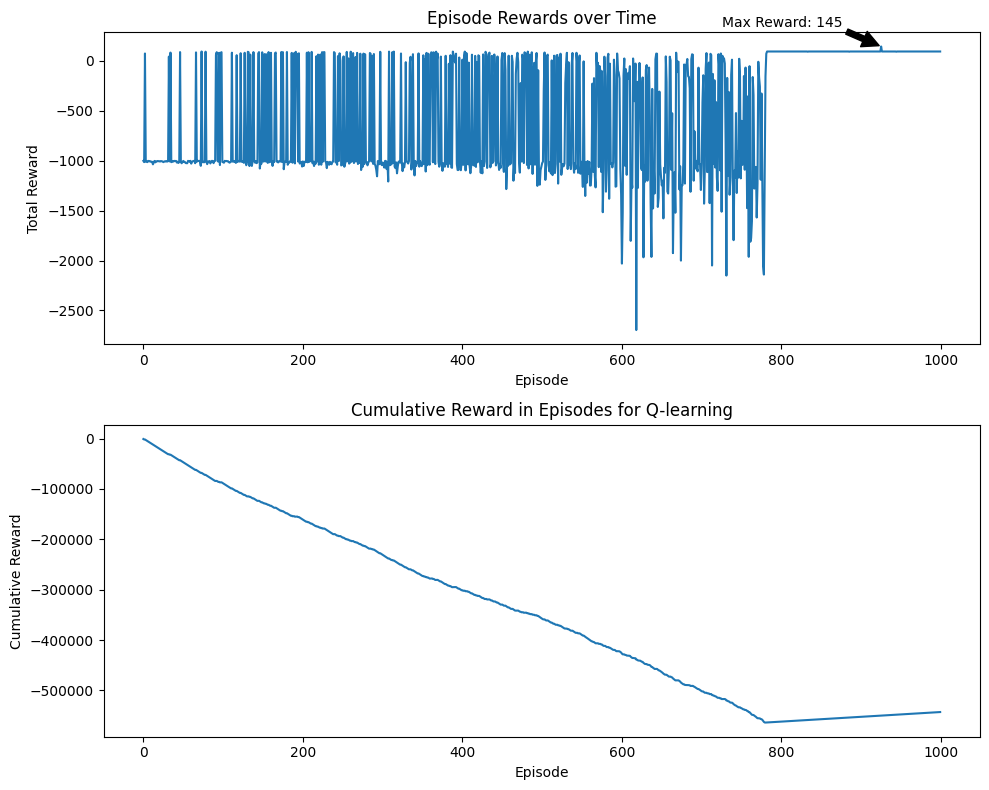

Average reward per episode after 1000 episodes: -542.885
Episode where agent consistently finds gold: 3


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class WumpusWorld:
    def __init__(self, size=4):
        self.size = size
        self.reset()

    def reset(self):
        self.agent_pos = (0, 0)
        self.gold_pos = (self.size - 1, self.size - 1)
        self.pits = {(1, 1), (2, 2), (3, 0)}
        self.wumpus_pos = (3, 3)
        self.is_wumpus_alive = True
        self.has_arrow = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1  # Agent position
        state[self.gold_pos] = 2  # Gold position
        for pit in self.pits:
            state[pit] = 3  # Pit positions
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 4  # Wumpus position
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1  # Small penalty for each step to encourage shorter paths
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)
        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

class Agent:
    def __init__(self, state_size, action_size, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        return np.argmax(self.q_table[state])

    def learn(self, num_episodes):
        episode_rewards = []
        consecutive_successful_episodes = 0
        first_consistent_episode = None

        for episode in range(1, num_episodes + 1):
            state = env.reset()
            state_idx = self._state_to_index(state)
            total_reward = 0
            done = False
            steps = 0

            while not done:
                action = self.choose_action(state_idx)
                next_state, reward, done = env.step(action)
                next_state_idx = self._state_to_index(next_state)

                self.q_table[state_idx, action] = (1 - self.alpha) * self.q_table[state_idx, action] + \
                    self.alpha * (reward + self.gamma * np.max(self.q_table[next_state_idx]))

                state_idx = next_state_idx
                total_reward += reward
                steps += 1

            episode_rewards.append(total_reward)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if total_reward >= 100 and steps <= 5:
                consecutive_successful_episodes += 1
                if consecutive_successful_episodes >= 5 and first_consistent_episode is None:
                    first_consistent_episode = episode
            else:
                consecutive_successful_episodes = 0

            print(f"Q-learning Episode {episode}/{num_episodes}, Total Reward: {total_reward}")

        return episode_rewards, first_consistent_episode

    def _state_to_index(self, state):
        return hash(tuple(state)) % self.state_size

if __name__ == "__main__":
    env = WumpusWorld()
    env_size = env.size  # Size of the environment grid
    num_actions = 5  # 4 movement actions + 1 shoot action
    ALPHA = 0.1  # Learning rate
    GAMMA = 0.9  # Discount factor
    EPSILON = 0.9  # Initial epsilon for epsilon-greedy exploration
    EPSILON_DECAY = 0.995  # Epsilon decay rate
    EPSILON_MIN = 0.01  # Minimum epsilon
    NUM_EPISODES = 1000  # Number of episodes to run

    agent = Agent(env_size * env_size, num_actions, ALPHA, GAMMA, EPSILON, EPSILON_DECAY, EPSILON_MIN)

    episode_rewards, first_consistent_episode = agent.learn(NUM_EPISODES)

    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Calculate cumulative rewards
    cumulative_rewards = np.cumsum(episode_rewards)
    # Calculate maximum reward achieved
    max_reward = np.max(episode_rewards)

    # Find the episode where the agent starts to consistently find gold
    success_threshold = 0.8  # Define a threshold for success rate
    success_episodes = [i for i, reward in enumerate(episode_rewards) if reward >= 1]  # Normalized reward for finding gold is 1
    if success_episodes:
        consistent_episode = min(success_episodes) + 1  # +1 to convert 0-based index to episode number
    else:
        consistent_episode = "Not achieved"

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for Q-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 200, max_reward + 200),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    # Print average reward per episode and the episode where the agent consistently finds gold
    print(f"Average reward per episode after {NUM_EPISODES} episodes: {avg_reward_per_episode}")
    print(f"Episode where agent consistently finds gold: {consistent_episode}")


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class WumpusWorld:
    def __init__(self, size=4):
        self.size = size
        self.reset()

    def reset(self):
        self.agent_pos = (0, 0)
        self.gold_pos = (self.size - 1, self.size - 1)
        self.pits = {(1, 1), (2, 2), (3, 0)}
        self.wumpus_pos = (3, 3)
        self.is_wumpus_alive = True
        self.has_arrow = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1  # Agent position
        state[self.gold_pos] = 2  # Gold position
        for pit in self.pits:
            state[pit] = 3  # Pit positions
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 4  # Wumpus position
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1  # Small penalty for each step to encourage shorter paths
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)
        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

class Agent:
    def __init__(self, state_size, action_size, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        return np.argmax(self.q_table[state])

    def learn(self, num_episodes):
        episode_rewards = []
        consecutive_successful_episodes = 0
        first_consistent_episode = None

        for episode in range(1, num_episodes + 1):
            state = env.reset()
            state_idx = self._state_to_index(state)
            total_reward = 0
            done = False
            steps = 0

            while not done:
                action = self.choose_action(state_idx)
                next_state, reward, done = env.step(action)
                next_state_idx = self._state_to_index(next_state)

                self.q_table[state_idx, action] = (1 - self.alpha) * self.q_table[state_idx, action] + \
                    self.alpha * (reward + self.gamma * np.max(self.q_table[next_state_idx]))

                state_idx = next_state_idx
                total_reward += reward
                steps += 1

            episode_rewards.append(total_reward)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if total_reward >= 100 and steps <= 5:
                consecutive_successful_episodes += 1
                if consecutive_successful_episodes >= 10 and first_consistent_episode is None:
                    first_consistent_episode = episode
            else:
                consecutive_successful_episodes = 0

            print(f"Q-learning Episode {episode}/{num_episodes}, Total Reward: {total_reward}")

        return episode_rewards, first_consistent_episode

    def _state_to_index(self, state):
        return hash(tuple(state)) % self.state_size

if __name__ == "__main__":
    env = WumpusWorld()
    env_size = env.size  # Size of the environment grid
    num_actions = 5  # 4 movement actions + 1 shoot action
    ALPHA = 0.1  # Learning rate
    GAMMA = 0.9  # Discount factor
    EPSILON = 0.9  # Initial epsilon for epsilon-greedy exploration
    EPSILON_DECAY = 0.995  # Epsilon decay rate
    EPSILON_MIN = 0.01  # Minimum epsilon
    NUM_EPISODES = 1000  # Number of episodes to run

    agent = Agent(env_size * env_size, num_actions, ALPHA, GAMMA, EPSILON, EPSILON_DECAY, EPSILON_MIN)

    episode_rewards, first_consistent_episode = agent.learn(NUM_EPISODES)

    # Calculate average reward per episode
    avg_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)
    avg_reward_per_episode = np.mean(episode_rewards)

    # Calculate cumulative rewards
    cumulative_rewards = np.cumsum(episode_rewards)
    # Calculate maximum reward achieved
    max_reward = np.max(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for Q-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    ax3.plot(avg_rewards)
    ax3.set_title('Average Reward per Episode')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Average Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {NUM_EPISODES} episodes: {avg_reward_per_episode}")
    print(f"First episode where agent consistently finds gold for 10 consecutive episodes: {first_consistent_episode}")


Q-learning Episode 1/1000, Total Reward: -1007
Q-learning Episode 2/1000, Total Reward: -1009
Q-learning Episode 3/1000, Total Reward: -1002
Q-learning Episode 4/1000, Total Reward: -1007
Q-learning Episode 5/1000, Total Reward: -1001
Q-learning Episode 6/1000, Total Reward: -1002
Q-learning Episode 7/1000, Total Reward: -1015
Q-learning Episode 8/1000, Total Reward: -1045
Q-learning Episode 9/1000, Total Reward: -1001
Q-learning Episode 10/1000, Total Reward: -1026
Q-learning Episode 11/1000, Total Reward: -1004
Q-learning Episode 12/1000, Total Reward: -1005
Q-learning Episode 13/1000, Total Reward: -1037
Q-learning Episode 14/1000, Total Reward: -1008
Q-learning Episode 15/1000, Total Reward: -1011
Q-learning Episode 16/1000, Total Reward: -1007
Q-learning Episode 17/1000, Total Reward: -1001
Q-learning Episode 18/1000, Total Reward: -1005
Q-learning Episode 19/1000, Total Reward: -1009
Q-learning Episode 20/1000, Total Reward: -1016
Q-learning Episode 21/1000, Total Reward: -1009
Q

Average reward per episode after 1000 episodes: -518.393
First episode where agent consistently finds gold for 10 consecutive episodes: None


Q-learning Episode 1/1000, Total Reward: -1008
Q-learning Episode 2/1000, Total Reward: -1007
Q-learning Episode 3/1000, Total Reward: -1010
Q-learning Episode 4/1000, Total Reward: -1017
Q-learning Episode 5/1000, Total Reward: -1003
Q-learning Episode 6/1000, Total Reward: -1006
Q-learning Episode 7/1000, Total Reward: 74
Q-learning Episode 8/1000, Total Reward: -1004
Q-learning Episode 9/1000, Total Reward: -1006
Q-learning Episode 10/1000, Total Reward: -1007
Q-learning Episode 11/1000, Total Reward: -1018
Q-learning Episode 12/1000, Total Reward: -1003
Q-learning Episode 13/1000, Total Reward: -1017
Q-learning Episode 14/1000, Total Reward: -1005
Q-learning Episode 15/1000, Total Reward: -1034
Q-learning Episode 16/1000, Total Reward: -1009
Q-learning Episode 17/1000, Total Reward: -1002
Q-learning Episode 18/1000, Total Reward: -1007
Q-learning Episode 19/1000, Total Reward: -1002
Q-learning Episode 20/1000, Total Reward: -1003
Q-learning Episode 21/1000, Total Reward: -1034
Q-le

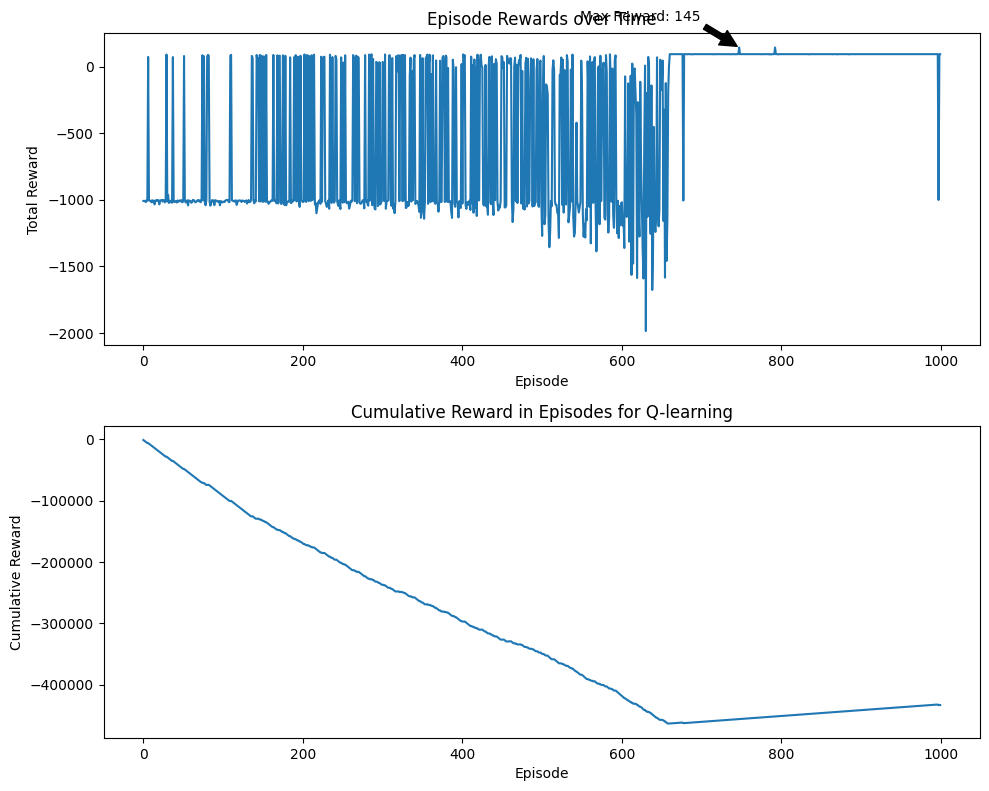

Average reward per episode after 1000 episodes: -432.87
First episode where agent consistently finds gold for 10 consecutive episodes: 661


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class WumpusWorld:
    def __init__(self, size=4):
        self.size = size
        self.reset()

    def reset(self):
        self.agent_pos = (0, 0)
        self.gold_pos = (self.size - 1, self.size - 1)
        self.pits = {(1, 1), (2, 2), (3, 0)}
        self.wumpus_pos = (3, 3)
        self.is_wumpus_alive = True
        self.has_arrow = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1  # Agent position
        state[self.gold_pos] = 2  # Gold position
        for pit in self.pits:
            state[pit] = 3  # Pit positions
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 4  # Wumpus position
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1  # Small penalty for each step to encourage shorter paths
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)
        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

class Agent:
    def __init__(self, state_size, action_size, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        return np.argmax(self.q_table[state])

    def learn(self, num_episodes):
        episode_rewards = []
        consecutive_successful_episodes = 0
        consistent_success_threshold = 10  # Number of consecutive successful episodes to define consistency
        first_consistent_episode = None

        for episode in range(1, num_episodes + 1):
            state = env.reset()
            state_idx = self._state_to_index(state)
            total_reward = 0
            done = False
            steps = 0

            while not done:
                action = self.choose_action(state_idx)
                next_state, reward, done = env.step(action)
                next_state_idx = self._state_to_index(next_state)

                self.q_table[state_idx, action] = (1 - self.alpha) * self.q_table[state_idx, action] + \
                    self.alpha * (reward + self.gamma * np.max(self.q_table[next_state_idx]))

                state_idx = next_state_idx
                total_reward += reward
                steps += 1

            episode_rewards.append(total_reward)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if total_reward >= 95:
                consecutive_successful_episodes += 1
                if consecutive_successful_episodes >= consistent_success_threshold and first_consistent_episode is None:
                    first_consistent_episode = episode - consecutive_successful_episodes + 1
            else:
                consecutive_successful_episodes = 0

            print(f"Q-learning Episode {episode}/{num_episodes}, Total Reward: {total_reward}")

        return episode_rewards, first_consistent_episode

    def _state_to_index(self, state):
        return hash(tuple(state)) % self.state_size

if __name__ == "__main__":
    env = WumpusWorld()
    env_size = env.size  # Size of the environment grid
    num_actions = 5  # 4 movement actions + 1 shoot action
    ALPHA = 0.1  # Learning rate
    GAMMA = 0.9  # Discount factor
    EPSILON = 0.9  # Initial epsilon for epsilon-greedy exploration
    EPSILON_DECAY = 0.995  # Epsilon decay rate
    EPSILON_MIN = 0.01  # Minimum epsilon
    NUM_EPISODES = 1000  # Number of episodes to run

    agent = Agent(env_size * env_size, num_actions, ALPHA, GAMMA, EPSILON, EPSILON_DECAY, EPSILON_MIN)

    episode_rewards, first_consistent_episode = agent.learn(NUM_EPISODES)

    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Calculate cumulative rewards
    cumulative_rewards = np.cumsum(episode_rewards)
    # Calculate maximum reward achieved
    max_reward = np.max(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for Q-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 200, max_reward + 200),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    # Print average reward per episode and the episode where the agent consistently finds gold
    print(f"Average reward per episode after {NUM_EPISODES} episodes: {avg_reward_per_episode}")
    print(f"First episode where agent consistently finds gold for 10 consecutive episodes: {first_consistent_episode}")


ه

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count

# Define named tuple for transitions with 'done'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wumpus World Environment
class WumpusWorld:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size))
        self.agent_pos = (0, 0)
        self.gold_pos = (3, 3)
        self.wumpus_pos = (1, 2)
        self.pits = [(2, 2), (1, 1)]
        self.grid[self.gold_pos] = 1
        self.grid[self.wumpus_pos] = 2
        for pit in self.pits:
            self.grid[pit] = -1
        self.has_arrow = True
        self.is_wumpus_alive = True
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.agent_pos] = 1
        state[self.gold_pos] = 2
        if self.is_wumpus_alive:
            state[self.wumpus_pos] = 3
        for pit in self.pits:
            state[pit] = -1
        return state.flatten()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.size - 1, y + 1)
        elif action == 4:  # Shoot action
            reward = self.shoot_arrow()
            return self._get_state(), reward, False

        reward = -1
        done = False

        if (x, y) == self.gold_pos:
            reward = 100
            done = True
        elif (x, y) in self.pits:
            reward = -1000
            done = True
        elif (x, y) == self.wumpus_pos:
            if self.is_wumpus_alive:
                reward = -1000
                done = True

        self.agent_pos = (x, y)

        return self._get_state(), reward, done

    def shoot_arrow(self):
        if not self.has_arrow:
            return -1
        self.has_arrow = False

        # Determine if Wumpus is killed
        ax, ay = self.agent_pos
        wx, wy = self.wumpus_pos

        if (ax == wx and abs(ay - wy) <= 1) or (ay == wy and abs(ax - wx) <= 1):
            self.is_wumpus_alive = False
            return 50

        return -1

# Replay Memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQNAgent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.size * env.size
        self.action_size = 5  # 4 movement actions + 1 shoot action
        self.memory = ReplayMemory(MEMORY_CAPACITY)
        self.gamma = GAMMA
        self.epsilon = EPS_START
        self.epsilon_decay = EPS_DECAY
        self.epsilon_min = EPS_END
        self.learning_rate = LR
        self.policy_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net = DQN(self.state_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, next_state, reward, done)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, self.state_size)

        state_batch = torch.cat(batch.state).view(-1, self.state_size)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (~done_batch))

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - TAU) + policy_param.data * TAU)

    def learn(self, num_episodes):
        episode_rewards = []
        cumulative_rewards = []

        for i_episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
                reward = torch.tensor([reward], device=device)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward.item()

                self.optimize_model()

                if done:
                    episode_rewards.append(total_reward)
                    print(f"Episode {i_episode + 1} finished after {t + 1} steps with total reward {total_reward}")
                    break

            cumulative_rewards.append(np.sum(episode_rewards))  # Accumulate total rewards

            if i_episode % 10 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return episode_rewards, cumulative_rewards

# Hyperparameters
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 800
TAU = 0.001
LR = 0.1
MEMORY_CAPACITY = 10000


# Main training loop
if __name__ == "__main__":
    env = WumpusWorld()
    agent = DQNAgent(env)
    num_episodes = 1000

    episode_rewards, cumulative_rewards = agent.learn(num_episodes)
    max_reward = np.max(episode_rewards)
    # Calculate average reward per episode
    avg_reward_per_episode = np.mean(episode_rewards)

    # Plotting both rewards
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')

    ax2.plot(cumulative_rewards)
    ax2.set_title('Cumulative Reward in Episodes for DQ-learning')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Reward')

    # Annotate maximum reward achieved
    ax1.annotate(f'Max Reward: {max_reward}', xy=(np.argmax(episode_rewards), max_reward), xytext=(np.argmax(episode_rewards) - 20, max_reward + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

    print(f"Average reward per episode after {num_episodes} episodes: {avg_reward_per_episode}")


Episode 1 finished after 11 steps with total reward -1010
Episode 2 finished after 9 steps with total reward -1008
Episode 3 finished after 3 steps with total reward -1002
Episode 4 finished after 26 steps with total reward -1025
Episode 5 finished after 6 steps with total reward -1005
Episode 6 finished after 6 steps with total reward -1005
Episode 7 finished after 6 steps with total reward -1005
Episode 8 finished after 6 steps with total reward -1005
Episode 9 finished after 11 steps with total reward -1010
Episode 10 finished after 18 steps with total reward -1017
Episode 11 finished after 5 steps with total reward -1004
Episode 12 finished after 5 steps with total reward -1004
Episode 13 finished after 6 steps with total reward -1005
Episode 14 finished after 46 steps with total reward -994
Episode 15 finished after 23 steps with total reward -971
Episode 16 finished after 3 steps with total reward -1002
Episode 17 finished after 21 steps with total reward -1020
Episode 18 finishe

Average reward per episode after 1000 episodes: -922.697
